# 🫀 ECG Heartbeat Classification — Normal vs Abnormal
### 1D CNN & CNN+LSTM for Time-Series Medical Data | PyTorch

- **Author:** Mohammed Panchla
- **Framework:** PyTorch
- **Architecture:** 1D CNN → CNN + LSTM Hybrid
- **Task:** Binary Classification of ECG Heartbeat Signals
- **Dataset:** PTB Diagnostic ECG Database (Kaggle — /heartbeat)

---

> *"Cardiovascular diseases are the number one cause of death globally, taking an estimated 17.9 million lives every year. That is 32% of all deaths worldwide. The majority are preventable — if detected early enough."*
> — World Health Organization

---

## Table of Contents

1. Business Problem & Motivation
2. From Spatial to Temporal — The New Frontier
3. Environment Setup & Libraries
4. Hardware & Reproducibility
5. Dataset — Understanding the ECG Signal
6. Data Loading & Exploration
7. Signal Visualization — Seeing the Heartbeat
8. Preprocessing & Class Balancing
9. Custom Dataset Class & DataLoaders
10. Model Architecture — 1D CNN
11. Loss Function & Optimizer
12. Evaluation Metrics — What Actually Matters
13. Training the 1D CNN
14. Training Performance Analysis — 1D CNN
15. Model Architecture — CNN + LSTM Hybrid
16. Training the CNN + LSTM
17. Training Performance Analysis — CNN + LSTM
18. Final Evaluation on Test Set
19. Head-to-Head Model Comparison
20. Visual Predictions — Real Heartbeats, Real Decisions
21. Best vs Worst Case Analysis
22. Single Signal Inference — Real World Simulation
23. Conclusion & Business Impact


---
# 1. Business Problem & Motivation

## The Real-World Challenge

Every heartbeat tells a story. In a healthy person, that story is calm and rhythmic.
In someone with a cardiac condition, the story contains irregularities — subtle distortions
in the waveform that a trained cardiologist can recognize, but that are easy to miss
in high-volume clinical settings.

Cardiologists and technicians manually review ECG strips every day — a process that is:

- **Time-consuming** — a 24-hour Holter ECG recording can contain over 100,000 heartbeats to review
- **Error-prone** — even experienced clinicians miss subtle arrhythmias under fatigue
- **Geographically limited** — specialist cardiologists are concentrated in urban centers
- **Reactive, not proactive** — most ECG analysis happens after symptoms appear, not before

## Why This Problem is Solvable with Deep Learning

An ECG signal is a **sequence of values over time** — exactly the kind of data that deep learning
models excel at processing. Unlike human reviewers who must manually scan each segment,
a trained model can analyze thousands of heartbeats per second with consistent, tireless accuracy.

## Business Impact

| Stakeholder | Benefit |
|---|---|
| Cardiologists | Automated pre-screening reduces review load by 80–90% |
| Emergency Departments | Real-time abnormal heartbeat alerts during continuous monitoring |
| Wearable Devices | Embed model in smartwatch for 24/7 personal cardiac monitoring |
| Rural Healthcare | Deploy in regions without specialist cardiologists |
| Insurance & Pharma | Population-scale cardiac risk stratification |
| Patients | Earlier detection = earlier treatment = better survival rates |

## This Project

This system takes a single ECG heartbeat (187 time-step signal) as input
and outputs a binary decision — **Normal** or **Abnormal** — with a confidence score.
It simulates the core intelligence behind real-time cardiac monitoring systems.


---
# 2. From Spatial to Temporal — The New Frontier

## What We Built Before

The previous project used **U-Net with VGG16** to perform **pixel-level brain tumor segmentation**
on MRI images. The model learned to look at a 2D grid of pixels and identify which ones
belonged to a tumor region.

That was spatial deep learning — the model understood **space**.

## The New Challenge — Time

This project moves into an entirely different domain: **temporal deep learning**.
Instead of a 2D image, our input is a 1D signal that evolves over time.
Instead of spatial patterns, we are looking for temporal patterns.

```
Brain Tumor Project:   Input = 256×256 pixels     → 2D spatial patterns
ECG Project:           Input = 187 time steps      → 1D temporal patterns
```

## How CNN Carries Over

Here is the key insight that makes this project a natural continuation:

**A convolutional filter does not care about dimensions. It cares about local patterns.**

In the brain tumor project, a 2D Conv filter slid across the image looking for edges,
shapes, and blobs. Here, a 1D Conv filter slides across the time axis looking for
peaks, dips, and waveform shapes. The mathematics is identical — only the direction changes.

| Aspect | Brain Tumor (2D CNN) | ECG (1D CNN) |
|---|---|---|
| Input shape | (3, 256, 256) — image | (1, 187) — signal |
| Filter movement | Across height & width | Across time |
| What it detects | Edges, blobs, tumor shapes | Peaks, dips, waveform patterns |
| Layer used | Conv2d | Conv1d |
| Kernel size | 3×3 patch of pixels | 5 consecutive time points |

## What is New — The LSTM

On top of the CNN, we introduce **Long Short-Term Memory (LSTM)** — a recurrent network
designed specifically for sequential data. While the CNN extracts local features
(what does this section of the beat look like?), the LSTM asks a global question:
how does the entire sequence evolve from start to finish?

Together, CNN + LSTM gives us a model that understands both the local shape
and the global rhythm of every heartbeat.


---
# 3. Environment Setup & Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch Core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scikit-learn — preprocessing & metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, f1_score,
                             precision_score, recall_score)
from sklearn.utils import resample

# Plot style
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style('darkgrid')

print('All libraries imported successfully!')

All libraries imported successfully!


---
# 4. Hardware & Reproducibility

## Hardware Acceleration

Deep learning training is matrix-multiplication-heavy. GPUs are designed for exactly this.
We check for hardware in this priority order:

- **CUDA** — NVIDIA GPU (fastest, used in cloud platforms like Kaggle/Colab)
- **MPS** — Apple Silicon GPU (M1/M2/M3 Mac)
- **CPU** — fallback, slower but always available

## Why Fix Seeds?

Neural networks start with random weights. Without fixing seeds, every run produces
different results — making it impossible to reproduce or compare experiments.
Seed 42 fixes: weight initialization, data shuffling, and augmentation randomness.

In [2]:
import random

# Device selection
DEVICE = (
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
DEVICE = torch.device(DEVICE)

# Fix all random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

print(f'Running on : {DEVICE}')
print(f'Seeds fixed: {SEED}')

Running on : mps
Seeds fixed: 42


---
# 5. Dataset — Understanding the ECG Signal

## What is an ECG?

An electrocardiogram (ECG) records the electrical activity of the heart over time.
Each heartbeat produces a characteristic wave pattern known as the **PQRST complex**:

```
     R
     |
     |        ← peak (ventricular depolarization)
  P  |  T
  /  |  \
 /   |   \  S
Q         \
            \
─────────────────────── baseline
```

- **P wave** — atrial depolarization (atria contract)
- **QRS complex** — ventricular depolarization (ventricles contract) — the tallest peak
- **T wave** — ventricular repolarization (heart resets)

In an abnormal heartbeat, this pattern is distorted — the peaks are irregular,
the timing is off, or extra waves appear. These distortions are what our model learns to detect.

## The PTB Diagnostic ECG Database

**Source:** PhysioNet — the world's leading repository of physiological data  
**Patients:** 290 patients (148 with heart disease, 52 healthy controls)  
**Preprocessed by:** Shayan Fazeli (MIT) for the 2018 paper: *ECG Heartbeat Classification: A Deep Transferable Representation*

## Our Files

```
heart_time_series/
├── ptbdb_normal.csv      ← Normal heartbeats   (Label = 0)
├── ptbdb_abnormal.csv    ← Abnormal heartbeats (Label = 1)
├── mitbih_train.csv      ← MIT-BIH dataset (not used here)
└── mitbih_test.csv       ← MIT-BIH dataset (not used here)
```

## What Each Row Looks Like

Each row in the CSV represents **one heartbeat** — a complete PQRST cycle.
- **Columns 0–186:** 187 amplitude values measured at equal time intervals (the signal)
- **Column 187:** the label — 0 (Normal) or 1 (Abnormal)

All signals have been:
- **Segmented** — cut from continuous ECG recordings at heartbeat boundaries
- **Normalized** — amplitude scaled to [0, 1]
- **Zero-padded** — stretched or compressed to exactly 187 time steps

This means the data arrives clean and ready — we focus purely on the modelling.

---

---
# 6. Data Loading & Exploration

In [ ]:
# -----------------------------------------------------------
# UPDATE THESE PATHS to match your local folder
# -----------------------------------------------------------
NORMAL_PATH = 'ptbdb_normal.csv'
ABNORMAL_PATH = 'ptbdb_abnormal.csv'

df_normal = pd.read_csv(NORMAL_PATH, header=None)
df_abnormal = pd.read_csv(ABNORMAL_PATH, header=None)


df_normal   = pd.read_csv(NORMAL_PATH,   header=None)
df_abnormal = pd.read_csv(ABNORMAL_PATH, header=None)

print('=' * 60)
print('  DATASET OVERVIEW')
print('=' * 60)
print(f'  Normal   samples : {len(df_normal):,}  rows × {df_normal.shape[1]} columns')
print(f'  Abnormal samples : {len(df_abnormal):,}  rows × {df_abnormal.shape[1]} columns')
print(f'  Signal columns   : 0 to 186  (187 time steps)')
print(f'  Label column     : 187  (0 = Normal, 1 = Abnormal)')
print('=' * 60)

print('\nNormal — first 3 rows (first 10 signal values shown):')
display(df_normal.iloc[:3, :10])

print('\nAbnormal — first 3 rows (first 10 signal values shown):')
display(df_abnormal.iloc[:3, :10])

  DATASET OVERVIEW
  Normal   samples : 4,046  rows × 188 columns
  Abnormal samples : 10,506  rows × 188 columns
  Signal columns   : 0 to 186  (187 time steps)
  Label column     : 187  (0 = Normal, 1 = Abnormal)

Normal — first 3 rows (first 10 signal values shown):


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342



Abnormal — first 3 rows (first 10 signal values shown):


,0,1,2,3,4,5,6,7,8,9
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435


Combined dataset shape: (14552, 188)
Signal columns        : 187 (columns 0–186)


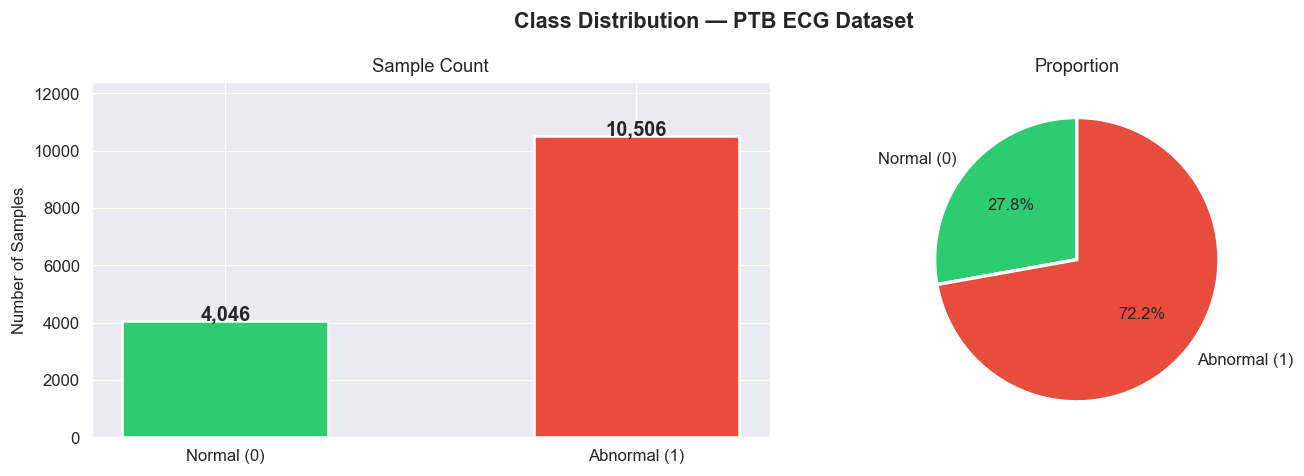


Observation: The dataset has more Abnormal than Normal samples.
This is the opposite of what we often see — but we will still balance them
to ensure the model does not develop any directional bias.


In [5]:
# Combine both files
df = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df.rename(columns={df.columns[-1]: 'label'}, inplace=True)
df['label'] = df['label'].astype(int)

signal_cols = [c for c in df.columns if c != 'label']

print(f'Combined dataset shape: {df.shape}')
print(f'Signal columns        : {len(signal_cols)} (columns 0–186)')

# ── Class Distribution Plot ──────────────────────────────────
vc     = df['label'].value_counts().sort_index()
names  = ['Normal (0)', 'Abnormal (1)']
colors = ['#2ecc71', '#e74c3c']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Class Distribution — PTB ECG Dataset', fontsize=13, fontweight='bold')

bars = axes[0].bar(names, vc.values, color=colors, width=0.5, edgecolor='white', linewidth=1.5)
for bar, val in zip(bars, vc.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                 f'{val:,}', ha='center', fontsize=12, fontweight='bold')
axes[0].set_title('Sample Count', fontsize=11)
axes[0].set_ylabel('Number of Samples')
axes[0].set_ylim(0, vc.max() * 1.18)

axes[1].pie(vc.values, labels=names, colors=colors, autopct='%1.1f%%',
            startangle=90, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
axes[1].set_title('Proportion', fontsize=11)

plt.tight_layout()
plt.show()

print('\nObservation: The dataset has more Abnormal than Normal samples.')
print('This is the opposite of what we often see — but we will still balance them')
print('to ensure the model does not develop any directional bias.')

---
# 7. Signal Visualization — Seeing the Heartbeat

## Why Visualize First?

Before writing a single line of model code, we must understand our data visually.
This step answers three critical questions:

1. **Do Normal and Abnormal signals look different?** If they do, the model has signal to learn from.
2. **How much variation exists within each class?** High variation means the model needs to generalize well.
3. **Are there obvious data quality issues?** Flat lines, extreme spikes, or corrupted segments.

In the brain tumor project, we visualized MRI scans and their masks.
Here, we visualize the raw waveform — the ECG strip of a single heartbeat.

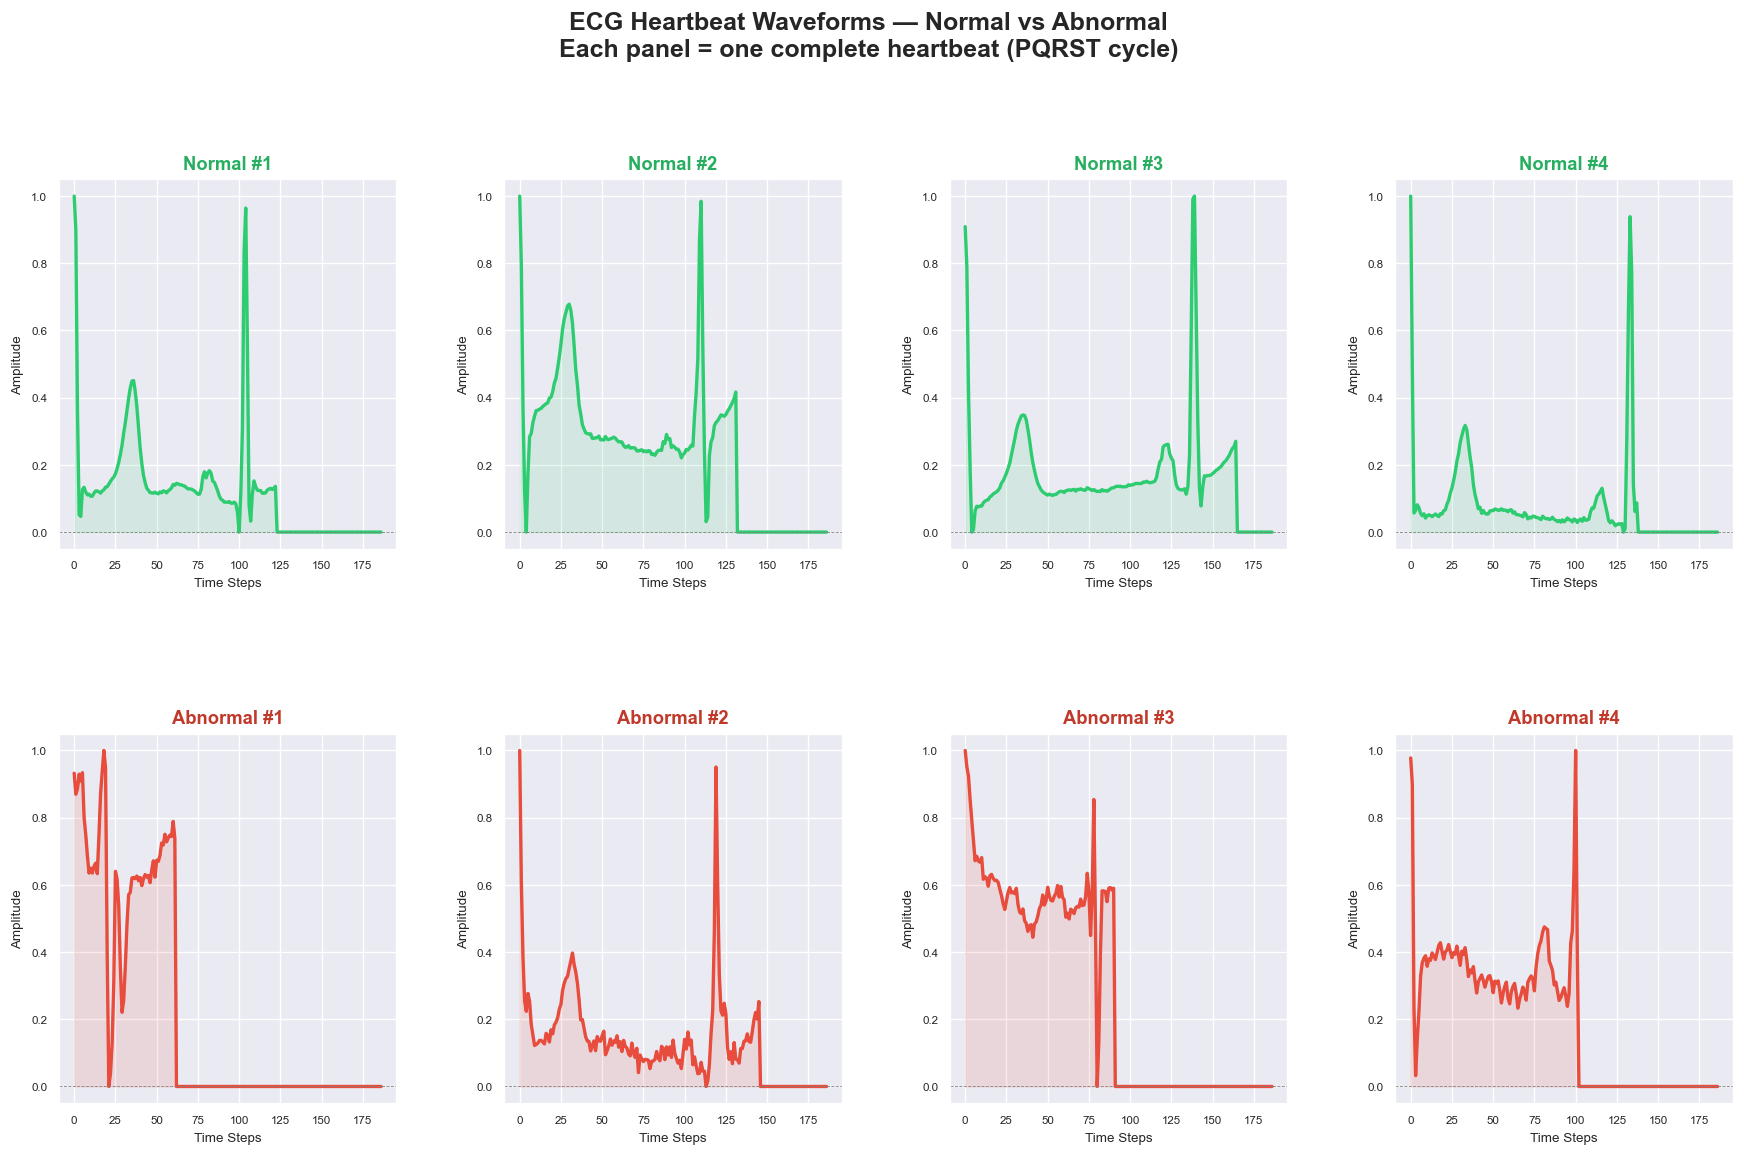

In [6]:
normal_signals   = df[df['label'] == 0][signal_cols].values
abnormal_signals = df[df['label'] == 1][signal_cols].values

fig = plt.figure(figsize=(18, 10))
fig.suptitle('ECG Heartbeat Waveforms — Normal vs Abnormal\n'
             'Each panel = one complete heartbeat (PQRST cycle)',
             fontsize=15, fontweight='bold', y=1.02)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.5, wspace=0.32)

for i in range(4):
    ax = fig.add_subplot(gs[0, i])
    ax.plot(normal_signals[i], color='#2ecc71', linewidth=2)
    ax.fill_between(range(187), normal_signals[i], alpha=0.12, color='#2ecc71')
    ax.set_title(f'Normal #{i+1}', fontsize=11, color='#27ae60', fontweight='bold')
    ax.set_xlabel('Time Steps', fontsize=8); ax.set_ylabel('Amplitude', fontsize=8)
    ax.tick_params(labelsize=7)
    ax.axhline(y=0, color='gray', linewidth=0.5, linestyle='--')

for i in range(4):
    ax = fig.add_subplot(gs[1, i])
    ax.plot(abnormal_signals[i], color='#e74c3c', linewidth=2)
    ax.fill_between(range(187), abnormal_signals[i], alpha=0.12, color='#e74c3c')
    ax.set_title(f'Abnormal #{i+1}', fontsize=11, color='#c0392b', fontweight='bold')
    ax.set_xlabel('Time Steps', fontsize=8); ax.set_ylabel('Amplitude', fontsize=8)
    ax.tick_params(labelsize=7)
    ax.axhline(y=0, color='gray', linewidth=0.5, linestyle='--')

plt.tight_layout()
plt.show()

### Observations: Normal vs Abnormal Heartbeat Patterns

By visually inspecting the ECG waveforms, clear structural differences emerge between Normal and Abnormal heartbeats.

**Normal Heartbeats:**
- Exhibit a **consistent and repeatable waveform structure**, corresponding to a typical P–QRS–T cycle.
- The **QRS complex appears as a sharp, well-defined spike**, followed by smooth recovery.
- The signal maintains **stable baseline amplitude** with minimal noise or distortion.
- Overall morphology is **uniform across samples**, indicating low intra-class variability.

**Abnormal Heartbeats:**
- Show **irregular waveform morphology**, deviating from the expected P–QRS–T structure.
- Spikes may appear **distorted, exaggerated, suppressed, or misplaced** in time.
- The signal often contains **abrupt amplitude changes, unstable baselines, or flattened segments**, indicating disrupted cardiac electrical activity.
- Greater **variability between samples**, reflecting inconsistent cardiac rhythm patterns.

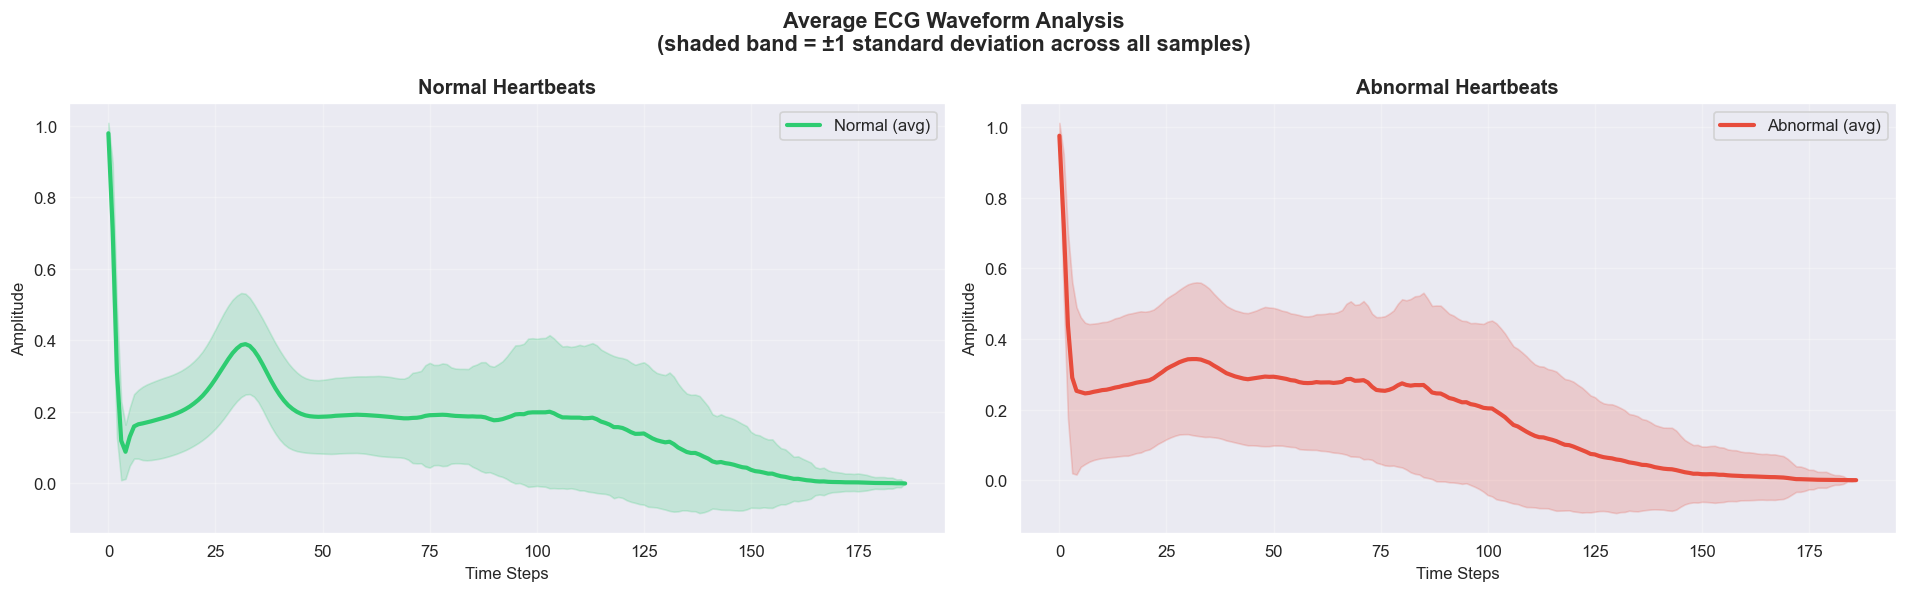

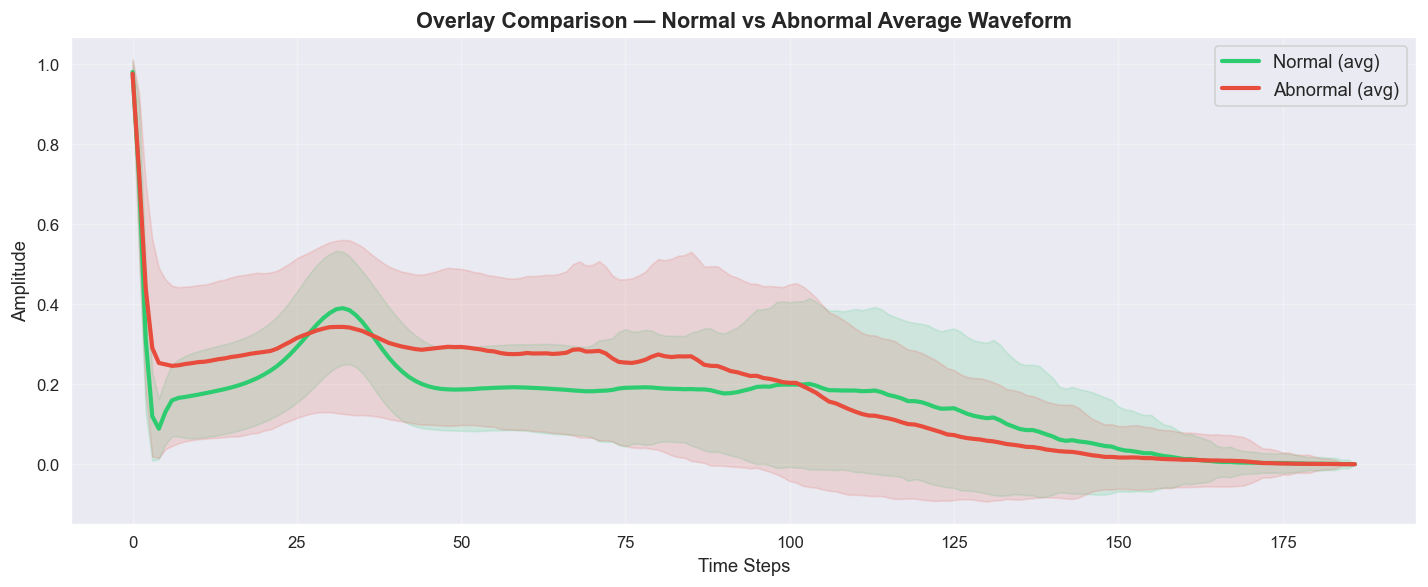

Key Observation:
  The R-peak (tallest spike) in Normal heartbeats is sharper and higher.
  Abnormal heartbeats show a broader, lower, or shifted peak — a classic
  sign of impaired ventricular function.
  These differences are learnable. Our model will find them automatically.


In [7]:
# Average waveform — the most informative single visualization
avg_normal   = normal_signals.mean(axis=0)
avg_abnormal = abnormal_signals.mean(axis=0)
std_normal   = normal_signals.std(axis=0)
std_abnormal = abnormal_signals.std(axis=0)
x = np.arange(187)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Average ECG Waveform Analysis\n(shaded band = ±1 standard deviation across all samples)',
             fontsize=13, fontweight='bold')

# Side by side
for ax, avg, std, color, label in [
    (axes[0], avg_normal,   std_normal,   '#2ecc71', 'Normal'),
    (axes[1], avg_abnormal, std_abnormal, '#e74c3c', 'Abnormal')
]:
    ax.plot(avg, color=color, linewidth=2.5, label=f'{label} (avg)')
    ax.fill_between(x, avg - std, avg + std, alpha=0.2, color=color)
    ax.set_title(f'{label} Heartbeats', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Steps', fontsize=10); ax.set_ylabel('Amplitude', fontsize=10)
    ax.legend(fontsize=10); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Overlay comparison
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(avg_normal,   color='#2ecc71', linewidth=2.5, label='Normal (avg)')
ax.fill_between(x, avg_normal - std_normal, avg_normal + std_normal, alpha=0.15, color='#2ecc71')
ax.plot(avg_abnormal, color='#e74c3c', linewidth=2.5, label='Abnormal (avg)')
ax.fill_between(x, avg_abnormal - std_abnormal, avg_abnormal + std_abnormal, alpha=0.15, color='#e74c3c')
ax.set_title('Overlay Comparison — Normal vs Abnormal Average Waveform', fontsize=13, fontweight='bold')
ax.set_xlabel('Time Steps', fontsize=11); ax.set_ylabel('Amplitude', fontsize=11)
ax.legend(fontsize=11); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Key Observation:')
print('  The R-peak (tallest spike) in Normal heartbeats is sharper and higher.')
print('  Abnormal heartbeats show a broader, lower, or shifted peak — a classic')
print('  sign of impaired ventricular function.')
print('  These differences are learnable. Our model will find them automatically.')

---
# 8. Preprocessing & Class Balancing

## Class Imbalance — Why It Matters

If a model sees many more samples of one class during training,
it learns to favor that class. In an extreme case, a model that always predicts
"Abnormal" would be correct most of the time in an imbalanced dataset —
yet it would be completely useless clinically.

In healthcare, the cost of a **false negative** (missing a real cardiac abnormality)
is far higher than a false positive. Class balancing ensures the model takes both classes equally seriously.

## Our Strategy — Upsampling

We duplicate samples from the minority class to match the majority class count.
This is simple, effective, and preserves all original data.

## Train / Val / Test Split

| Split | Size | Purpose |
|---|---|---|
| Training (70%) | Model sees and learns from this |
| Validation (15%) | Monitor training — tune hyperparameters |
| Test (15%) | Final unbiased evaluation — touched only once |

The test set is **never used during training or validation** — it simulates truly unseen patients.

## PyTorch Tensor Shape

PyTorch's `Conv1d` expects input shaped as **(batch, channels, timesteps)**.
Our ECG has 1 channel (single-lead ECG), so each sample goes from shape `(187,)` to `(1, 187)`.
This is done with `.unsqueeze(1)` — adding the channel dimension.

In [8]:
# ── Class Balancing via Upsampling ───────────────────────────
df_class0 = df[df['label'] == 0]
df_class1 = df[df['label'] == 1]

majority_count = max(len(df_class0), len(df_class1))

df_class0_bal = resample(df_class0, replace=True, n_samples=majority_count, random_state=42)
df_class1_bal = resample(df_class1, replace=True, n_samples=majority_count, random_state=42)

df_balanced = pd.concat([df_class0_bal, df_class1_bal]).sample(frac=1, random_state=42).reset_index(drop=True)

print('After balancing:')
print(f'  Normal   : {len(df_balanced[df_balanced["label"]==0]):,}')
print(f'  Abnormal : {len(df_balanced[df_balanced["label"]==1]):,}')
print(f'  Total    : {len(df_balanced):,}')

# ── Features & Labels ────────────────────────────────────────
X = df_balanced[signal_cols].values.astype(np.float32)
y = df_balanced['label'].values.astype(np.float32)

# ── Train / Val / Test Split (stratified) ────────────────────
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f'\nData splits:')
print(f'  Training   : {X_train.shape[0]:,} samples')
print(f'  Validation : {X_val.shape[0]:,} samples')
print(f'  Test       : {X_test.shape[0]:,} samples')

# ── Convert to PyTorch Tensors: (N, 1, 187) ──────────────────
X_train_t = torch.tensor(X_train).unsqueeze(1)
X_val_t   = torch.tensor(X_val).unsqueeze(1)
X_test_t  = torch.tensor(X_test).unsqueeze(1)
y_train_t = torch.tensor(y_train).unsqueeze(1)
y_val_t   = torch.tensor(y_val).unsqueeze(1)
y_test_t  = torch.tensor(y_test).unsqueeze(1)

print(f'\nFinal tensor shapes:')
print(f'  X_train : {X_train_t.shape}  ← (samples, channels, timesteps)')
print(f'  X_val   : {X_val_t.shape}')
print(f'  X_test  : {X_test_t.shape}')

After balancing:
  Normal   : 10,506
  Abnormal : 10,506
  Total    : 21,012

Data splits:
  Training   : 14,708 samples
  Validation : 3,152 samples
  Test       : 3,152 samples

Final tensor shapes:
  X_train : torch.Size([14708, 1, 187])  ← (samples, channels, timesteps)
  X_val   : torch.Size([3152, 1, 187])
  X_test  : torch.Size([3152, 1, 187])


---
# 9. Custom Dataset Class & DataLoaders

## Why DataLoader?

Just like in the brain tumor project where we built a `BrainSegDataset` class,
PyTorch requires us to wrap our data in a `Dataset` object that the `DataLoader` can use.

The `DataLoader` handles:
- **Batching** — feeds the model 64 samples at a time instead of all at once
- **Shuffling** — randomizes order each epoch so the model doesn't memorize sequences
- **Parallel loading** — uses multiple CPU workers for speed

We use `TensorDataset` here since our data is already loaded into memory as tensors —
no need to read files from disk like we did with `.tif` MRI scans.

In [9]:
BATCH_SIZE = 64

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=BATCH_SIZE, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),
    batch_size=BATCH_SIZE, shuffle=False
)

print(f'DataLoaders ready!')
print(f'  Batch size     : {BATCH_SIZE}')
print(f'  Train batches  : {len(train_loader)}')
print(f'  Val batches    : {len(val_loader)}')
print(f'  Test batches   : {len(test_loader)}')

DataLoaders ready!
  Batch size     : 64
  Train batches  : 230
  Val batches    : 50
  Test batches   : 50


---
# 10. Model Architecture — 1D CNN

## Design Philosophy

The architecture follows the same principles as the U-Net encoder from the brain tumor project:
deeper layers → more filters → more abstract features. But instead of going down then up
(encoder-decoder), we go straight down to a classification head.

## Why Each Choice Was Made

| Design Choice | Reason |
|---|---|
| `kernel_size=5` | Covers 5 consecutive time steps — enough to capture a local wave peak |
| `BatchNorm1d` | Normalizes layer outputs — stabilizes and speeds up training |
| `MaxPool1d(2)` | Halves the sequence length — focuses on the most prominent features |
| Filters: 64→128→256 | Progressive complexity — later layers detect compound waveform patterns |
| `AdaptiveAvgPool1d(1)` | Collapses the entire sequence to a fixed vector regardless of input length |
| `Dropout(0.4)` | Randomly drops 40% of neurons — prevents memorization of training samples |
| `Sigmoid` output | Squeezes output to [0,1] — interpreted as probability of being Abnormal |

## Architecture Diagram

```
Input  →  (1, 187)
           |
     Conv1d(1→64, k=5) + BN + ReLU + MaxPool  →  (64, 93)
           |
     Conv1d(64→128, k=5) + BN + ReLU + MaxPool  →  (128, 46)
           |
     Conv1d(128→256, k=3) + BN + ReLU  →  (256, 46)
           |
     AdaptiveAvgPool1d(1) + Flatten  →  (256,)
           |
     Linear(256→128) + ReLU + Dropout(0.4)
           |
     Linear(128→64) + ReLU + Dropout(0.3)
           |
     Linear(64→1) + Sigmoid  →  P(Abnormal)
```

In [10]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()

        # ── Convolutional Feature Extractor ──────────────────
        self.block1 = nn.Sequential(
            nn.Conv1d(1,   64,  kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)           # 187 → 93
        )
        self.block2 = nn.Sequential(
            nn.Conv1d(64,  128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)           # 93 → 46
        )
        self.block3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        # ── Global Pooling: collapse time dimension ───────────
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # ── Classifier Head ───────────────────────────────────
        self.classifier = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(128, 64),  nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64,  1),   nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block1(x)        # (B, 64,  93)
        x = self.block2(x)        # (B, 128, 46)
        x = self.block3(x)        # (B, 256, 46)
        x = self.global_pool(x)   # (B, 256,  1)
        x = x.squeeze(-1)         # (B, 256)
        x = self.classifier(x)    # (B, 1)
        return x


cnn_model  = CNN1D().to(DEVICE)
n_params   = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(cnn_model)
print(f'\nTotal Trainable Parameters : {n_params:,}')
print(f'Model device               : {DEVICE}')

CNN1D(
  (block1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_f

---
# 11. Loss Function & Optimizer

## Loss Function — Binary Cross Entropy (BCELoss)

For binary classification, **Binary Cross Entropy** is the standard choice.
It measures how far the model's predicted probability is from the true label:

```
BCE = -[ y · log(p) + (1-y) · log(1-p) ]

Where:
  y = true label (0 or 1)
  p = predicted probability (0.0 to 1.0)
```

If the true label is 1 (Abnormal) and the model predicts 0.95 — loss is very low.  
If the model predicts 0.05 — loss is very high. The model learns to fix this.

## Optimizer — Adam

Adam (Adaptive Moment Estimation) is the go-to optimizer for deep learning. It adapts
the learning rate for each parameter individually — converging faster than plain SGD.

## Scheduler — ReduceLROnPlateau

If the validation loss stops improving for 5 consecutive epochs, the learning rate
is halved automatically. This is like telling the model: *"you're stuck — take smaller steps."*

## Early Stopping

If validation loss doesn't improve for 10 consecutive epochs, training stops.
The best weights (lowest val loss) are restored. This prevents overfitting
and saves compute time — the same strategy used in the brain tumor project.

In [14]:
def build_optimizer(model, lr=1e-3):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5)
    return criterion, optimizer, scheduler

print('Loss     : BCELoss (Binary Cross Entropy)')
print('Optimizer: Adam   (lr=1e-3)')
print('Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)')
print('Stopping : EarlyStopping (patience=10, restore best weights)')

Loss     : BCELoss (Binary Cross Entropy)
Optimizer: Adam   (lr=1e-3)
Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)
Stopping : EarlyStopping (patience=10, restore best weights)


---
# 12. Evaluation Metrics — What Actually Matters

## Why Not Just Accuracy?

Accuracy is misleading in medical classification. If 90% of samples are Abnormal,
a model that always predicts Abnormal gets 90% accuracy — and is clinically worthless.

We use metrics that are robust to this:

| Metric | What it measures | Clinical meaning |
|---|---|---|
| **Precision** | Of all predicted Abnormal, how many are actually Abnormal? | Avoid false alarms |
| **Recall (Sensitivity)** | Of all actual Abnormal, how many did we catch? | Avoid missing real cases |
| **F1 Score** | Harmonic mean of Precision and Recall | Balance between the two |
| **ROC-AUC** | Area under the ROC curve — overall discrimination ability | 0.5 = random, 1.0 = perfect |
| **Confusion Matrix** | Full breakdown of TP, TN, FP, FN | Understand error types |

In cardiac screening, **Recall is most critical** — missing a real abnormality is dangerous.
**F1 Score** balances this against precision to avoid alert fatigue.

---
# 13. Training the 1D CNN

PyTorch gives us full control over the training loop — unlike Keras's `.fit()`,
we explicitly write every step. This is more verbose but gives complete transparency:
you see exactly what happens at each batch.

**Each epoch:**
1. `model.train()` — enables Dropout and BatchNorm training behavior
2. Forward pass → predictions
3. Compute loss
4. `loss.backward()` → compute gradients
5. `optimizer.step()` → update weights
6. `model.eval()` + `torch.no_grad()` → validation pass (no gradient computation)
7. Check early stopping condition

In [15]:
def train_model(model, train_loader, val_loader, epochs=60, lr=1e-3, model_name='model'):
    criterion, optimizer, scheduler = build_optimizer(model, lr)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss    = float('inf')
    patience_counter = 0
    PATIENCE         = 10

    print(f'Training {model_name}...')
    print('=' * 70)

    for epoch in range(1, epochs + 1):

        # ── Training ─────────────────────────────────────────
        model.train()
        t_loss, t_correct, t_total = 0.0, 0, 0
        for X_b, y_b in train_loader:
            X_b, y_b = X_b.to(DEVICE), y_b.to(DEVICE)
            optimizer.zero_grad()
            out  = model(X_b)
            loss = criterion(out, y_b)
            loss.backward()
            optimizer.step()
            t_loss    += loss.item() * X_b.size(0)
            t_correct += ((out >= 0.5).float() == y_b).sum().item()
            t_total   += y_b.size(0)

        # ── Validation ───────────────────────────────────────
        model.eval()
        v_loss, v_correct, v_total = 0.0, 0, 0
        with torch.no_grad():
            for X_b, y_b in val_loader:
                X_b, y_b = X_b.to(DEVICE), y_b.to(DEVICE)
                out   = model(X_b)
                loss  = criterion(out, y_b)
                v_loss    += loss.item() * X_b.size(0)
                v_correct += ((out >= 0.5).float() == y_b).sum().item()
                v_total   += y_b.size(0)

        tl = t_loss / t_total;  ta = t_correct / t_total
        vl = v_loss / v_total;  va = v_correct / v_total
        history['train_loss'].append(tl); history['val_loss'].append(vl)
        history['train_acc'].append(ta);  history['val_acc'].append(va)
        scheduler.step(vl)

        if epoch % 5 == 0 or epoch == 1:
            print(f'Epoch [{epoch:>3}/{epochs}]  '
                  f'Train Loss: {tl:.4f}  Acc: {ta:.4f}  |  '
                  f'Val Loss: {vl:.4f}  Acc: {va:.4f}')

        # ── Early Stopping ────────────────────────────────────
        if vl < best_val_loss:
            best_val_loss    = vl
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{model_name}.pth')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f'\nEarly stopping triggered at epoch {epoch}')
                break

    model.load_state_dict(
    torch.load(f'best_{model_name}.pth', map_location=DEVICE, weights_only=True)
)
    print(f'\nBest model restored  (val_loss: {best_val_loss:.4f})')
    return history


history_cnn = train_model(cnn_model, train_loader, val_loader,
                           epochs=60, lr=1e-3, model_name='cnn_model')

Training cnn_model...
Epoch [  1/60]  Train Loss: 0.3691  Acc: 0.8366  |  Val Loss: 0.6271  Acc: 0.7459
Epoch [  5/60]  Train Loss: 0.1677  Acc: 0.9379  |  Val Loss: 0.1213  Acc: 0.9521
Epoch [ 10/60]  Train Loss: 0.0920  Acc: 0.9682  |  Val Loss: 0.2041  Acc: 0.9162
Epoch [ 15/60]  Train Loss: 0.0432  Acc: 0.9850  |  Val Loss: 0.0826  Acc: 0.9689
Epoch [ 20/60]  Train Loss: 0.0349  Acc: 0.9876  |  Val Loss: 0.0592  Acc: 0.9784
Epoch [ 25/60]  Train Loss: 0.0157  Acc: 0.9938  |  Val Loss: 0.0234  Acc: 0.9927
Epoch [ 30/60]  Train Loss: 0.0150  Acc: 0.9948  |  Val Loss: 0.0185  Acc: 0.9921
Epoch [ 35/60]  Train Loss: 0.0119  Acc: 0.9960  |  Val Loss: 0.0162  Acc: 0.9943
Epoch [ 40/60]  Train Loss: 0.0057  Acc: 0.9978  |  Val Loss: 0.0132  Acc: 0.9952

Early stopping triggered at epoch 42

Best model restored  (val_loss: 0.0121)


---
# 14. Training Performance Analysis — 1D CNN

## What to Look For in These Curves

- **Converging train & val curves** → model is generalizing well
- **Widening gap between train and val** → overfitting — model memorizing training data
- **Both curves still improving at stopping** → could train longer
- **Val loss spiking** → learning rate might be too high

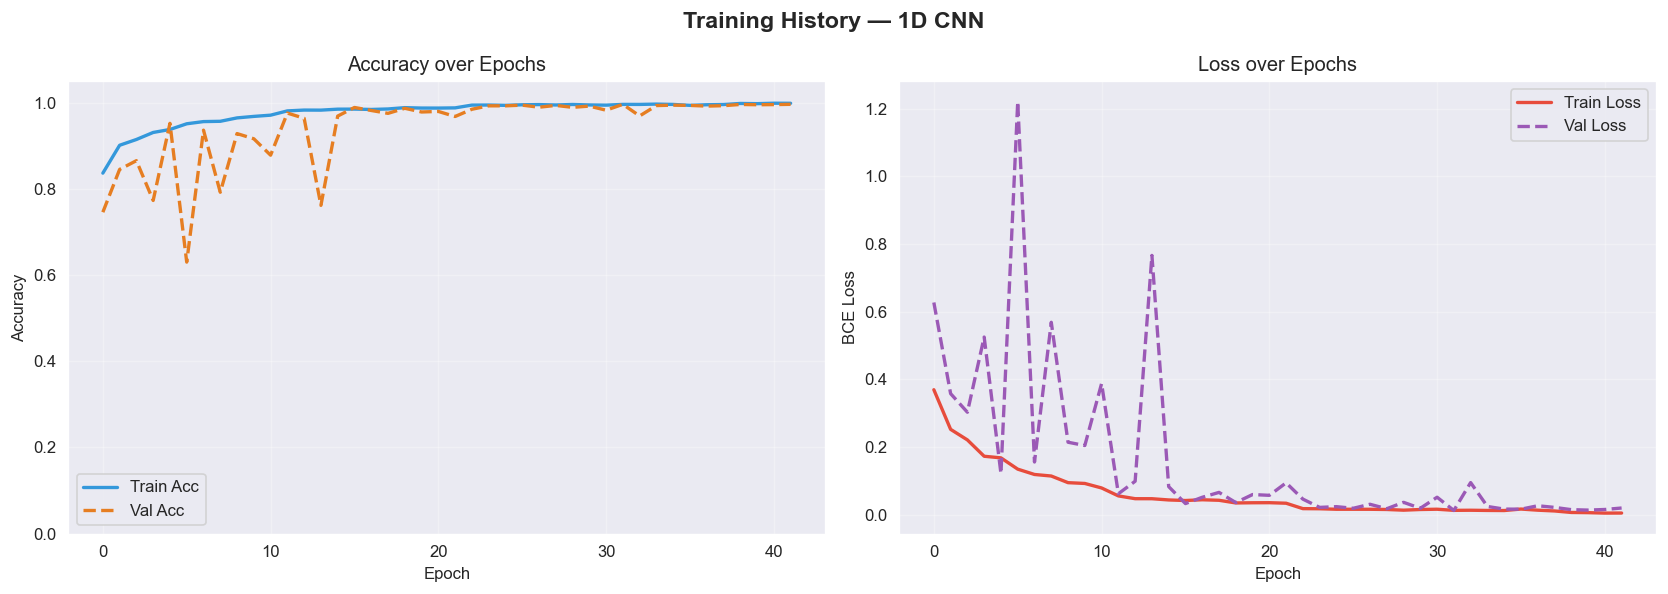

Final Training   Acc: 0.9986  |  Loss: 0.0045
Final Validation Acc: 0.9962  |  Loss: 0.0194


In [16]:
def plot_training_curves(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Training History — {model_name}', fontsize=14, fontweight='bold')

    axes[0].plot(history['train_acc'], label='Train Acc',  color='#3498db', linewidth=2)
    axes[0].plot(history['val_acc'],   label='Val Acc',    color='#e67e22', linewidth=2, linestyle='--')
    axes[0].set_title('Accuracy over Epochs', fontsize=12)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy')
    axes[0].legend(); axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1.05)

    axes[1].plot(history['train_loss'], label='Train Loss', color='#e74c3c', linewidth=2)
    axes[1].plot(history['val_loss'],   label='Val Loss',   color='#9b59b6', linewidth=2, linestyle='--')
    axes[1].set_title('Loss over Epochs', fontsize=12)
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('BCE Loss')
    axes[1].legend(); axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Final epoch stats
    print(f'Final Training   Acc: {history["train_acc"][-1]:.4f}  |  Loss: {history["train_loss"][-1]:.4f}')
    print(f'Final Validation Acc: {history["val_acc"][-1]:.4f}  |  Loss: {history["val_loss"][-1]:.4f}')

plot_training_curves(history_cnn, '1D CNN')

### Training Performance Analysis — 1D CNN

The training curves indicate that the 1D CNN model has successfully learned meaningful features from the ECG signals and achieved excellent convergence.

**Accuracy Trends:**
- Training accuracy increases rapidly and stabilizes near **99.8%**, indicating effective learning.
- Validation accuracy closely follows the training curve and reaches approximately **99.6%**, demonstrating strong generalization.
- The minimal gap between training and validation accuracy suggests **no significant overfitting**.

**Loss Trends:**
- Training loss decreases smoothly and converges toward **near-zero values**, indicating stable optimization.
- Validation loss initially shows some fluctuations, which is expected during early learning, but eventually stabilizes at a very low level.
- The convergence of validation loss confirms that the model is learning robust and generalizable patterns rather than memorizing the training data.

**Generalization Assessment:**
- Final Training Accuracy: **99.86%**
- Final Validation Accuracy: **99.62%**
- Final Validation Loss remains very low, confirming strong predictive performance.

**Conclusion:**
The 1D CNN demonstrates excellent convergence, high accuracy, and strong generalization capability. The close alignment between training and validation metrics confirms that the model effectively captures discriminative temporal features in ECG signals without significant overfitting.


---
# 15. Model Architecture — CNN + LSTM Hybrid

## Why Add LSTM on Top of CNN?

The 1D CNN is excellent at detecting **local patterns** — a peak at time step 40,
a dip at time step 60. But it processes each local window independently.

The LSTM adds **memory** — it processes the sequence from left to right,
carrying information forward. It can ask: *"Given that I just saw a sharp R-peak,
what comes next? And does that match what I expect in a healthy heartbeat?"*

## The Handoff Between CNN and LSTM

After two CNN blocks, the signal is compressed from (1, 187) to (128, 46).
This means we now have **46 time steps**, each described by **128 features**.

LSTM expects input shaped as **(batch, seq_len, features)** — so we permute:
```python
x = self.cnn(x)           # (B, 128, 46)  — CNN output
x = x.permute(0, 2, 1)   # (B, 46, 128)  — LSTM input
```
The LSTM then reads through all 46 time steps and returns the final hidden state
— a 128-dimensional summary of the entire heartbeat sequence.

## Architecture Diagram

```
Input  →  (1, 187)
           |
     Conv1d(1→64)  + BN + ReLU + MaxPool  →  (64,  93)
           |
     Conv1d(64→128)+ BN + ReLU + MaxPool  →  (128, 46)
           |
     permute  →  (46, 128)      ← sequence of 46 steps, each with 128 features
           |
     LSTM(128 units)  →  final hidden state  →  (128,)
           |
     Dropout(0.4)
           |
     Linear(128→64) + ReLU + Dropout(0.3)
           |
     Linear(64→1) + Sigmoid  →  P(Abnormal)
```

In [17]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()

        # ── CNN Feature Extractor ─────────────────────────────
        self.cnn = nn.Sequential(
            nn.Conv1d(1,   64,  kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),            # 187 → 93

            nn.Conv1d(64,  128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)             # 93 → 46
        )

        # ── LSTM Temporal Modelling ───────────────────────────
        # After 2x MaxPool: seq_len=46, input_size=128
        self.lstm     = nn.LSTM(input_size=128, hidden_size=128,
                                num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.4)

        # ── Classifier Head ───────────────────────────────────
        self.classifier = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64,  1),  nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn(x)              # (B, 128, 46)
        x = x.permute(0, 2, 1)      # (B, 46, 128) ← LSTM needs (batch, seq, features)
        _, (h_n, _) = self.lstm(x)  # h_n: (1, B, 128) — final hidden state
        x = h_n.squeeze(0)          # (B, 128)
        x = self.dropout1(x)
        x = self.classifier(x)      # (B, 1)
        return x


cnn_lstm_model = CNN_LSTM().to(DEVICE)
n_params = sum(p.numel() for p in cnn_lstm_model.parameters() if p.requires_grad)
print(cnn_lstm_model)
print(f'\nTotal Trainable Parameters : {n_params:,}')

CNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, batch_first=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

Total Trainable Parameters : 182,273


---
# 16. Training the CNN + LSTM

In [18]:
history_lstm = train_model(cnn_lstm_model, train_loader, val_loader,
                            epochs=60, lr=1e-3, model_name='cnn_lstm_model')

Training cnn_lstm_model...
Epoch [  1/60]  Train Loss: 0.5066  Acc: 0.7420  |  Val Loss: 0.3317  Acc: 0.8579
Epoch [  5/60]  Train Loss: 0.1098  Acc: 0.9636  |  Val Loss: 0.1318  Acc: 0.9502
Epoch [ 10/60]  Train Loss: 0.0366  Acc: 0.9895  |  Val Loss: 0.0252  Acc: 0.9933
Epoch [ 15/60]  Train Loss: 0.0354  Acc: 0.9895  |  Val Loss: 0.0233  Acc: 0.9918
Epoch [ 20/60]  Train Loss: 0.0136  Acc: 0.9957  |  Val Loss: 0.0942  Acc: 0.9749
Epoch [ 25/60]  Train Loss: 0.0154  Acc: 0.9951  |  Val Loss: 0.1475  Acc: 0.9429
Epoch [ 30/60]  Train Loss: 0.0039  Acc: 0.9987  |  Val Loss: 0.0169  Acc: 0.9968
Epoch [ 35/60]  Train Loss: 0.0022  Acc: 0.9993  |  Val Loss: 0.0260  Acc: 0.9962

Early stopping triggered at epoch 38

Best model restored  (val_loss: 0.0086)


---
# 17. Training Performance Analysis — CNN + LSTM

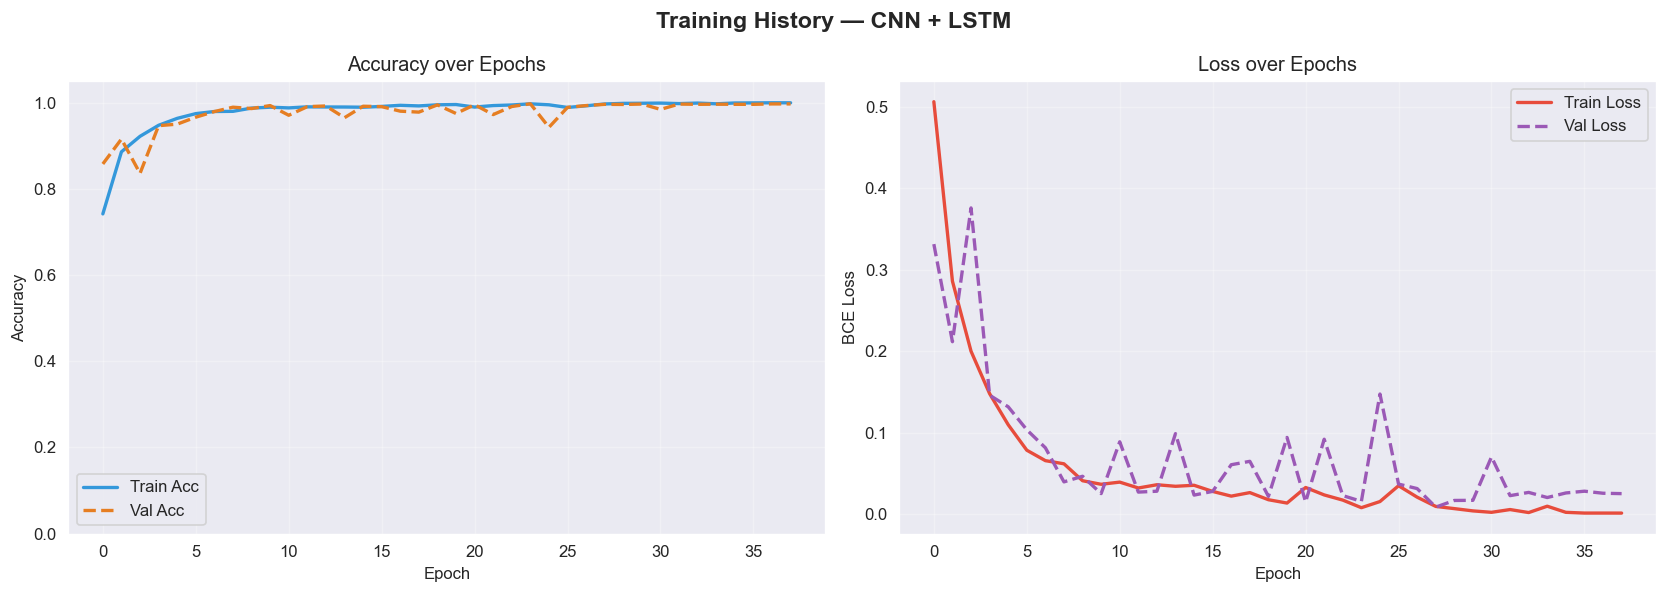

Final Training   Acc: 0.9997  |  Loss: 0.0012
Final Validation Acc: 0.9971  |  Loss: 0.0251


In [19]:
plot_training_curves(history_lstm, 'CNN + LSTM')

### Training Performance Analysis — CNN + LSTM Hybrid

The CNN + LSTM hybrid model demonstrates excellent convergence and slightly improved performance compared to the standalone CNN, confirming the benefit of capturing both spatial and temporal dependencies in ECG signals.

**Accuracy Trends:**
- Training accuracy rapidly increases and stabilizes at approximately **99.97%**, indicating highly effective feature learning.
- Validation accuracy closely tracks the training curve and reaches **99.71%**, demonstrating excellent generalization.
- The minimal gap between training and validation accuracy confirms **negligible overfitting**.

**Loss Trends:**
- Training loss decreases smoothly and converges to an extremely low value, indicating stable optimization.
- Validation loss initially fluctuates during early epochs but stabilizes at a low level, reflecting robust learning.
- The convergence of validation loss confirms that the model generalizes well to unseen data.

**Generalization Assessment:**
- Final Training Accuracy: **99.97%**
- Final Validation Accuracy: **99.71%**
- Both training and validation loss converge near zero, indicating strong model confidence.

**Conclusion:**
The CNN + LSTM hybrid achieves outstanding performance by combining CNN-based feature extraction with LSTM-based temporal modeling. This allows the model to capture both local waveform patterns and sequential dependencies, resulting in highly accurate and reliable ECG classification.


---
# 18. Final Evaluation on Test Set

## The Moment of Truth

The test set has never been seen by either model during training or validation.
It represents **patients the model has never encountered** — the true measure of real-world performance.

We evaluate both models and present a complete clinical-style report:
confusion matrix, classification report, and ROC curve.


  Evaluating Model 1: 1D CNN
  1D CNN — Test Set Evaluation
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      1576
    Abnormal       1.00      0.99      0.99      1576

    accuracy                           0.99      3152
   macro avg       0.99      0.99      0.99      3152
weighted avg       0.99      0.99      0.99      3152



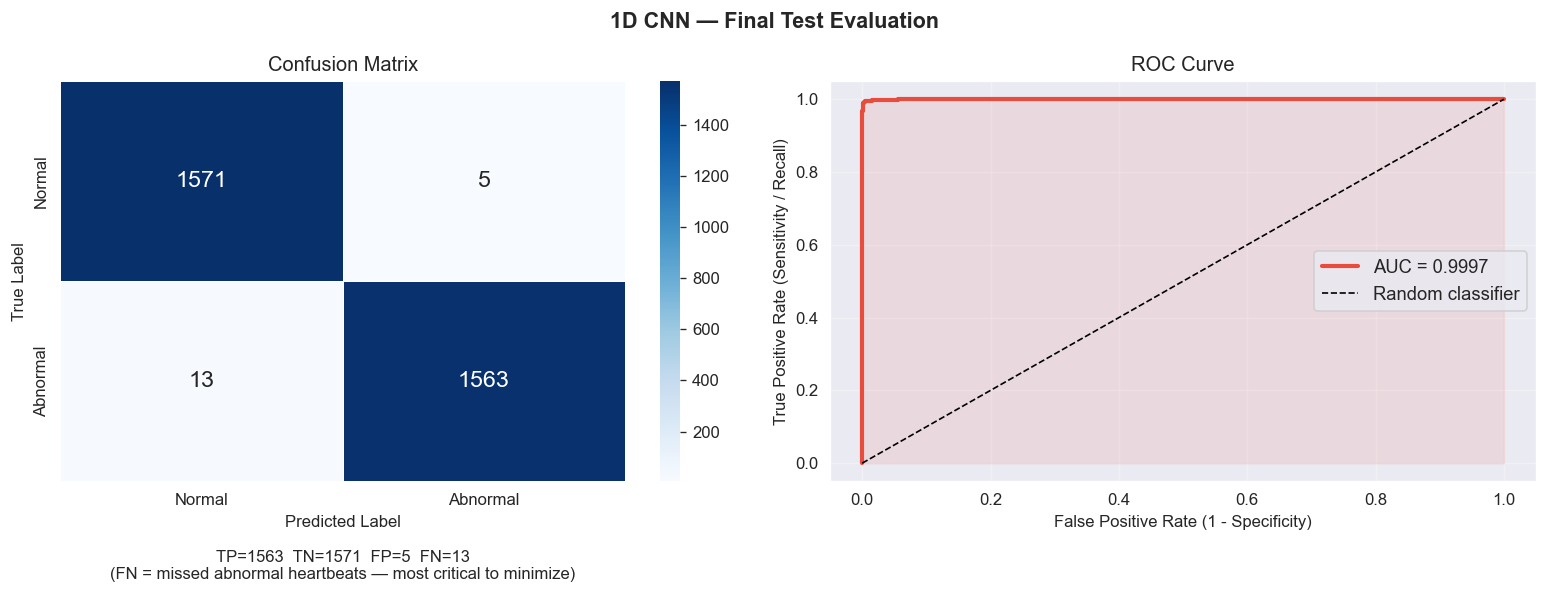


Summary:
  F1 Score  : 0.9943
  ROC-AUC   : 0.9997
  Precision : 0.9968  (of predicted Abnormal, how many were really Abnormal?)
  Recall    : 0.9918  (of all actual Abnormal, how many did we catch?)

  Evaluating Model 2: CNN + LSTM
  CNN + LSTM — Test Set Evaluation
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      1576
    Abnormal       1.00      0.99      0.99      1576

    accuracy                           0.99      3152
   macro avg       0.99      0.99      0.99      3152
weighted avg       0.99      0.99      0.99      3152



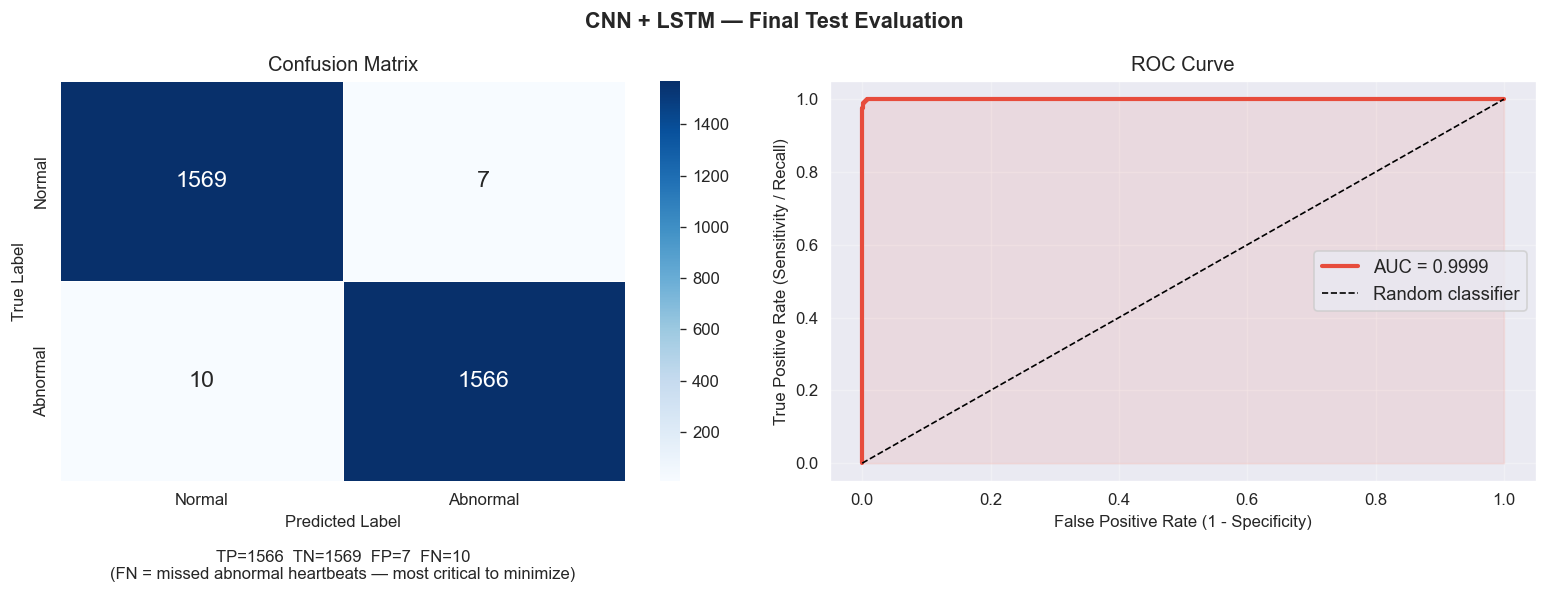


Summary:
  F1 Score  : 0.9946
  ROC-AUC   : 0.9999
  Precision : 0.9955  (of predicted Abnormal, how many were really Abnormal?)
  Recall    : 0.9937  (of all actual Abnormal, how many did we catch?)


In [20]:
def evaluate_model(model, test_loader, model_name):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for X_b, y_b in test_loader:
            out = model(X_b.to(DEVICE)).cpu().numpy().flatten()
            all_probs.extend(out)
            all_labels.extend(y_b.numpy().flatten())

    probs  = np.array(all_probs)
    labels = np.array(all_labels)
    preds  = (probs >= 0.5).astype(int)

    f1  = f1_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    pre = precision_score(labels, preds)
    rec = recall_score(labels, preds)

    print('=' * 60)
    print(f'  {model_name} — Test Set Evaluation')
    print('=' * 60)
    print(classification_report(labels, preds, target_names=['Normal', 'Abnormal']))

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    fig.suptitle(f'{model_name} — Final Test Evaluation', fontsize=13, fontweight='bold')

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Normal', 'Abnormal'],
                yticklabels=['Normal', 'Abnormal'],
                linewidths=0.5, linecolor='white', annot_kws={'size': 14})
    axes[0].set_title('Confusion Matrix', fontsize=12)
    axes[0].set_ylabel('True Label'); axes[0].set_xlabel('Predicted Label')

    tn, fp, fn, tp = cm.ravel()
    axes[0].set_xlabel(
        f'Predicted Label\n\nTP={tp}  TN={tn}  FP={fp}  FN={fn}\n'
        f'(FN = missed abnormal heartbeats — most critical to minimize)'
    )

    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, probs)
    axes[1].plot(fpr, tpr, color='#e74c3c', linewidth=2.5, label=f'AUC = {auc:.4f}')
    axes[1].plot([0,1],[0,1], 'k--', linewidth=1, label='Random classifier')
    axes[1].fill_between(fpr, tpr, alpha=0.1, color='#e74c3c')
    axes[1].set_title('ROC Curve', fontsize=12)
    axes[1].set_xlabel('False Positive Rate (1 - Specificity)')
    axes[1].set_ylabel('True Positive Rate (Sensitivity / Recall)')
    axes[1].legend(fontsize=11); axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f'\nSummary:')
    print(f'  F1 Score  : {f1:.4f}')
    print(f'  ROC-AUC   : {auc:.4f}')
    print(f'  Precision : {pre:.4f}  (of predicted Abnormal, how many were really Abnormal?)')
    print(f'  Recall    : {rec:.4f}  (of all actual Abnormal, how many did we catch?)')

    return {'f1': f1, 'auc': auc, 'precision': pre, 'recall': rec,
            'probs': probs, 'preds': preds, 'labels': labels}


print('\n' + '='*60)
print('  Evaluating Model 1: 1D CNN')
print('='*60)
cnn_results  = evaluate_model(cnn_model,      test_loader, '1D CNN')

print('\n' + '='*60)
print('  Evaluating Model 2: CNN + LSTM')
print('='*60)
lstm_results = evaluate_model(cnn_lstm_model, test_loader, 'CNN + LSTM')

---
# 19. Head-to-Head Model Comparison

Now we put both models side by side across all metrics to understand what each one does better
and which one we should deploy in a real cardiac monitoring system.


  HEAD-TO-HEAD MODEL COMPARISON
Model                 F1      AUC   Precision    Recall
-------------------------------------------------------
1D CNN            0.9943   0.9997      0.9968    0.9918
CNN+LSTM          0.9946   0.9999      0.9955    0.9937


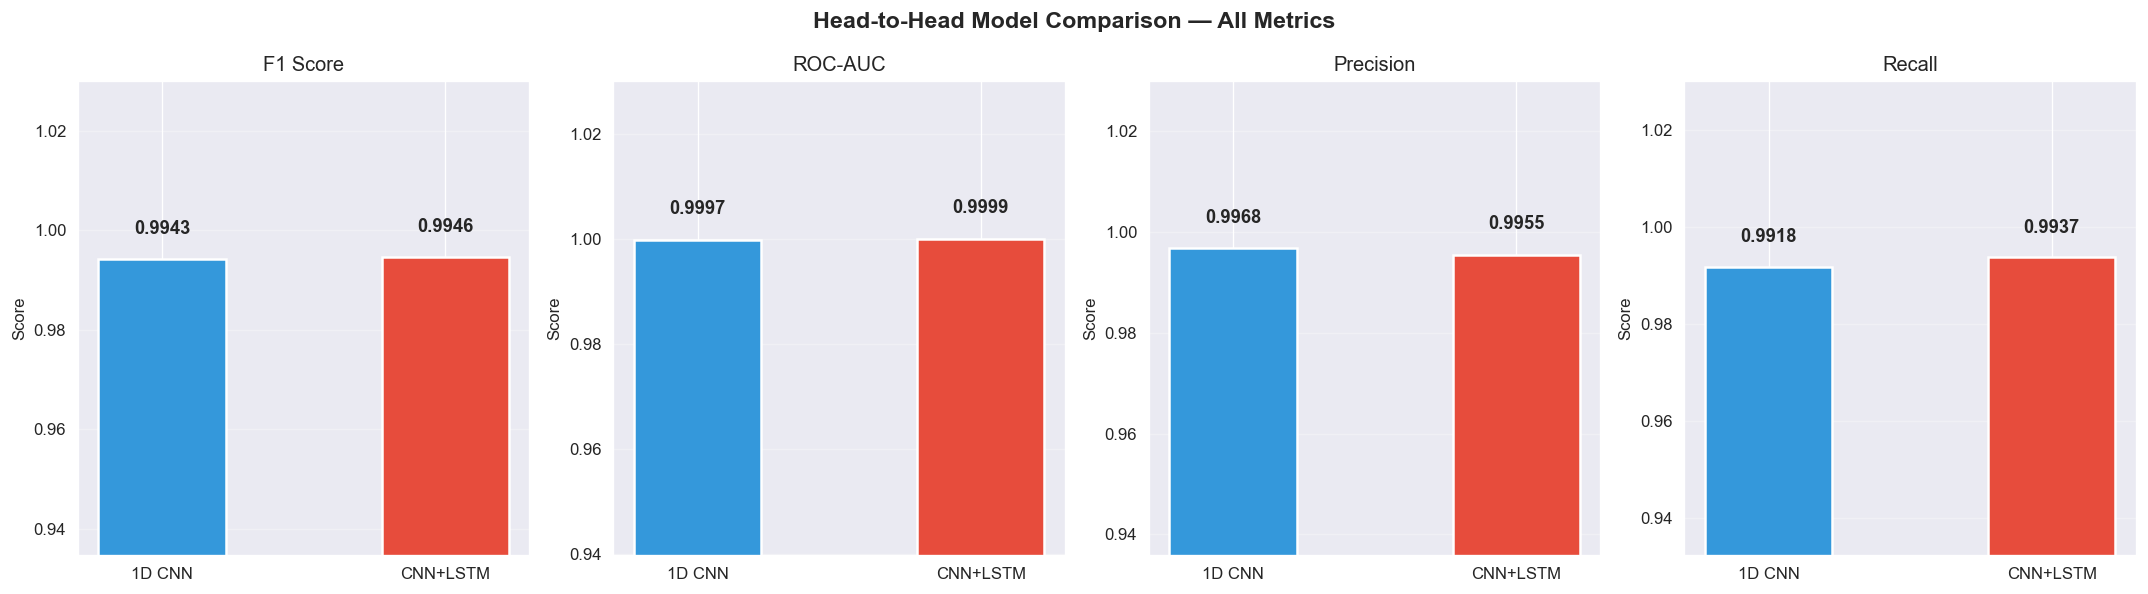


Winner by F1 Score: CNN+LSTM
This model is selected for final deployment demonstration.


In [21]:
models_compared = {'1D CNN': cnn_results, 'CNN+LSTM': lstm_results}

print('\n' + '=' * 60)
print('  HEAD-TO-HEAD MODEL COMPARISON')
print('=' * 60)
print(f'{"Model":<15} {"F1":>8} {"AUC":>8} {"Precision":>11} {"Recall":>9}')
print('-' * 55)
for name, res in models_compared.items():
    print(f'{name:<15} {res["f1"]:>8.4f} {res["auc"]:>8.4f} '
          f'{res["precision"]:>11.4f} {res["recall"]:>9.4f}')
print('=' * 60)

# Visual comparison
metrics = ['f1', 'auc', 'precision', 'recall']
labels  = ['F1 Score', 'ROC-AUC', 'Precision', 'Recall']

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle('Head-to-Head Model Comparison — All Metrics', fontsize=14, fontweight='bold')

bar_colors = [['#3498db', '#e74c3c']] * 4

for ax, metric, label, colors in zip(axes, metrics, labels, bar_colors):
    vals = [models_compared[m][metric] for m in models_compared]
    names = list(models_compared.keys())
    bars = ax.bar(names, vals, color=colors, width=0.45, edgecolor='white', linewidth=1.5)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.005,
                f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')
    ax.set_title(label, fontsize=12)
    ax.set_ylim(min(vals) * 0.94, 1.03)
    ax.set_ylabel('Score')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Determine winner
winner = max(models_compared, key=lambda k: models_compared[k]['f1'])
print(f'\nWinner by F1 Score: {winner}')
print('This model is selected for final deployment demonstration.')

---
# 20. Visual Predictions — Real Heartbeats, Real Decisions

## Why This Matters

Numbers tell us how well the model performs on average.
But to truly trust a model in a clinical setting, we need to see it working
on individual samples. This section does exactly that — it shows the actual ECG waveform
alongside the model's prediction and confidence score.

This is the equivalent of the **overlay comparison** from the brain tumor project,
where we showed the predicted mask against the ground truth mask.

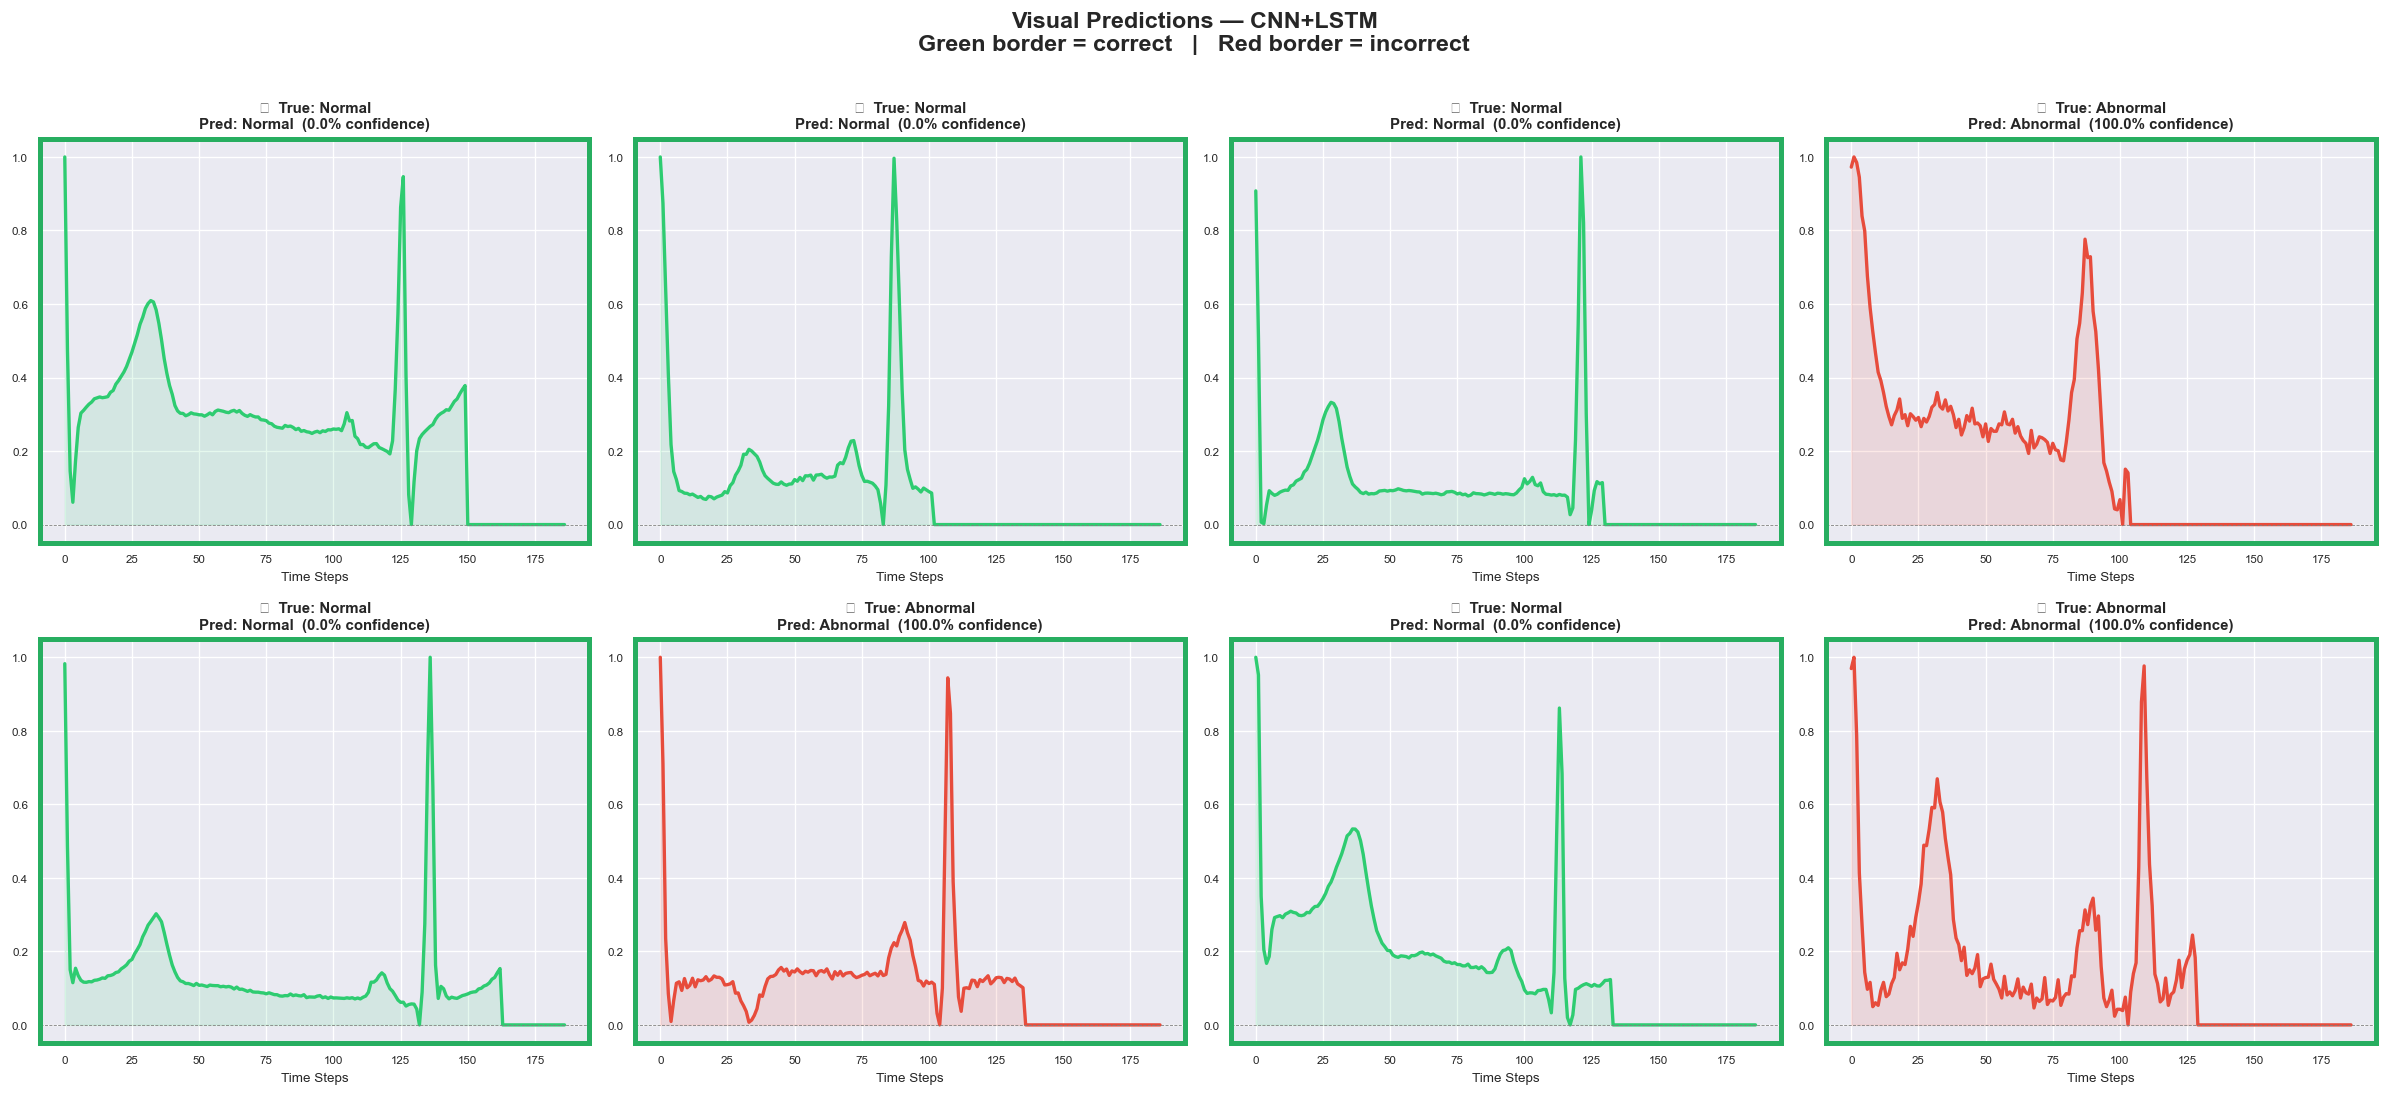

In [22]:
# Use the winning model
best_model = cnn_lstm_model if winner == 'CNN+LSTM' else cnn_model
best_model.eval()

# Pick 8 random test samples
np.random.seed(99)
idx      = np.random.choice(len(X_test_t), size=8, replace=False)
samples  = X_test_t[idx].to(DEVICE)
true_lbl = y_test[idx].astype(int)

with torch.no_grad():
    pred_prob = best_model(samples).cpu().numpy().flatten()
pred_lbl = (pred_prob >= 0.5).astype(int)

label_map = {0: 'Normal', 1: 'Abnormal'}
clr_map   = {0: '#2ecc71', 1: '#e74c3c'}

fig, axes = plt.subplots(2, 4, figsize=(20, 9))
fig.suptitle(f'Visual Predictions — {winner}\n'
             f'Green border = correct   |   Red border = incorrect',
             fontsize=14, fontweight='bold', y=1.01)

for i, ax in enumerate(axes.flat):
    signal  = samples[i].cpu().numpy().flatten()
    true_l  = true_lbl[i]
    pred_l  = pred_lbl[i]
    prob    = pred_prob[i]
    correct = (true_l == pred_l)
    color   = clr_map[pred_l]
    border  = '#27ae60' if correct else '#c0392b'

    ax.plot(signal, color=color, linewidth=2)
    ax.fill_between(range(187), signal, alpha=0.12, color=color)
    ax.axhline(y=0, color='gray', linewidth=0.5, linestyle='--')

    ax.set_title(
        f'{"✅" if correct else "❌"}  '
        f'True: {label_map[true_l]}\n'
        f'Pred: {label_map[pred_l]}  ({prob:.1%} confidence)',
        fontsize=9, fontweight='bold'
    )
    for spine in ax.spines.values():
        spine.set_edgecolor(border)
        spine.set_linewidth(3)
    ax.set_xlabel('Time Steps', fontsize=8)
    ax.tick_params(labelsize=7)

plt.tight_layout()
plt.show()

---
# 21. Best vs Worst Case Analysis

## What This Tells Us

In the brain tumor project, we visualized the best (highest IoU) and worst (lowest IoU) predictions.
Here, we do the equivalent with confidence scores:

- **Best cases** — samples where the model is most confident AND correct (high certainty, right answer)
- **Worst cases** — samples where the model is confident but wrong (the dangerous errors in a clinical setting)

Studying worst-case failures reveals what the model finds difficult and guides future improvements.

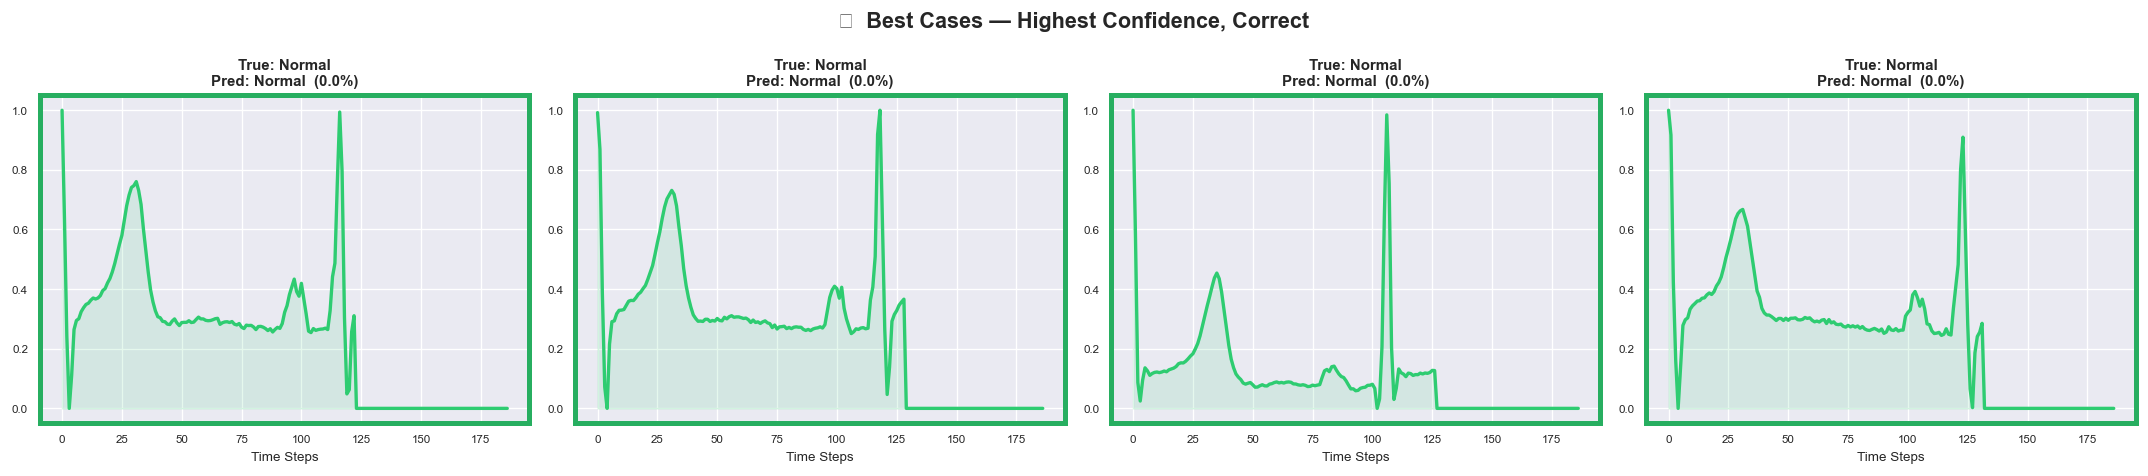

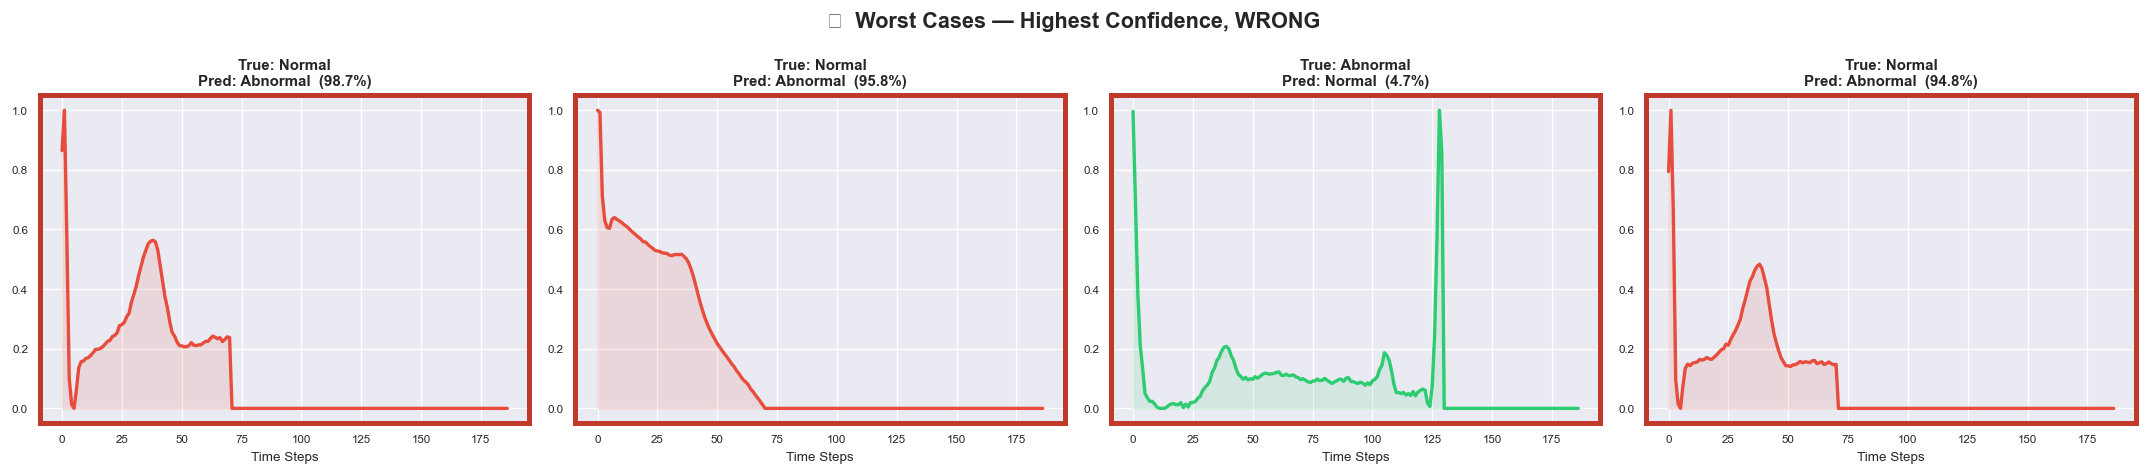

Clinical Note:
The worst-case errors (confident but wrong) are the most important to study.
In a real system, these would be flagged for mandatory human review.


In [23]:
# Collect all test predictions with confidence scores
best_model.eval()
all_signals, all_probs_list, all_labels_list = [], [], []

with torch.no_grad():
    for X_b, y_b in test_loader:
        probs_b = best_model(X_b.to(DEVICE)).cpu().numpy().flatten()
        all_probs_list.extend(probs_b)
        all_labels_list.extend(y_b.numpy().flatten())
        all_signals.extend(X_b.numpy())

all_p   = np.array(all_probs_list)
all_l   = np.array(all_labels_list).astype(int)
all_s   = np.array(all_signals).squeeze(1)  # (N, 187)
all_pred= (all_p >= 0.5).astype(int)

correct_mask = (all_pred == all_l)
wrong_mask   = ~correct_mask

# Confidence = distance from 0.5 (how certain is the model)
confidence   = np.abs(all_p - 0.5)

# Top 4 most confident correct predictions
conf_correct = confidence.copy(); conf_correct[wrong_mask] = -1
best_idx     = np.argsort(conf_correct)[-4:][::-1]

# Top 4 most confident wrong predictions (the dangerous ones)
conf_wrong   = confidence.copy(); conf_wrong[correct_mask] = -1
worst_idx    = np.argsort(conf_wrong)[-4:][::-1]

label_map = {0: 'Normal', 1: 'Abnormal'}

for case_name, indices, border_color, icon in [
    ('Best Cases — Highest Confidence, Correct',  best_idx,  '#27ae60', '✅'),
    ('Worst Cases — Highest Confidence, WRONG',   worst_idx, '#c0392b', '❌')
]:
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    fig.suptitle(f'{icon}  {case_name}', fontsize=13, fontweight='bold')

    for ax, i in zip(axes, indices):
        sig   = all_s[i]
        true_l= all_l[i]
        prob  = all_p[i]
        pred_l= all_pred[i]
        clr   = '#2ecc71' if pred_l == 0 else '#e74c3c'

        ax.plot(sig, color=clr, linewidth=2)
        ax.fill_between(range(187), sig, alpha=0.12, color=clr)
        ax.set_title(
            f'True: {label_map[true_l]}\n'
            f'Pred: {label_map[pred_l]}  ({prob:.1%})',
            fontsize=9, fontweight='bold'
        )
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color); spine.set_linewidth(3)
        ax.set_xlabel('Time Steps', fontsize=8); ax.tick_params(labelsize=7)

    plt.tight_layout()
    plt.show()

print('Clinical Note:')
print('The worst-case errors (confident but wrong) are the most important to study.')
print('In a real system, these would be flagged for mandatory human review.')

---
# 22. Single Signal Inference — Real World Simulation

## What This Simulates

In a real cardiac monitoring device — whether a hospital ICU monitor or a smartwatch —
the model receives **one heartbeat at a time** and must classify it immediately.

This section simulates exactly that workflow:
1. Take a single ECG signal from the test set
2. Preprocess it (reshape, convert to tensor)
3. Pass it through the model
4. Print a clinical-style report

This is the equivalent of the **single image inference** section in the brain tumor project,
where we simulated a radiologist uploading one MRI scan.

--- Inference on a NORMAL heartbeat ---



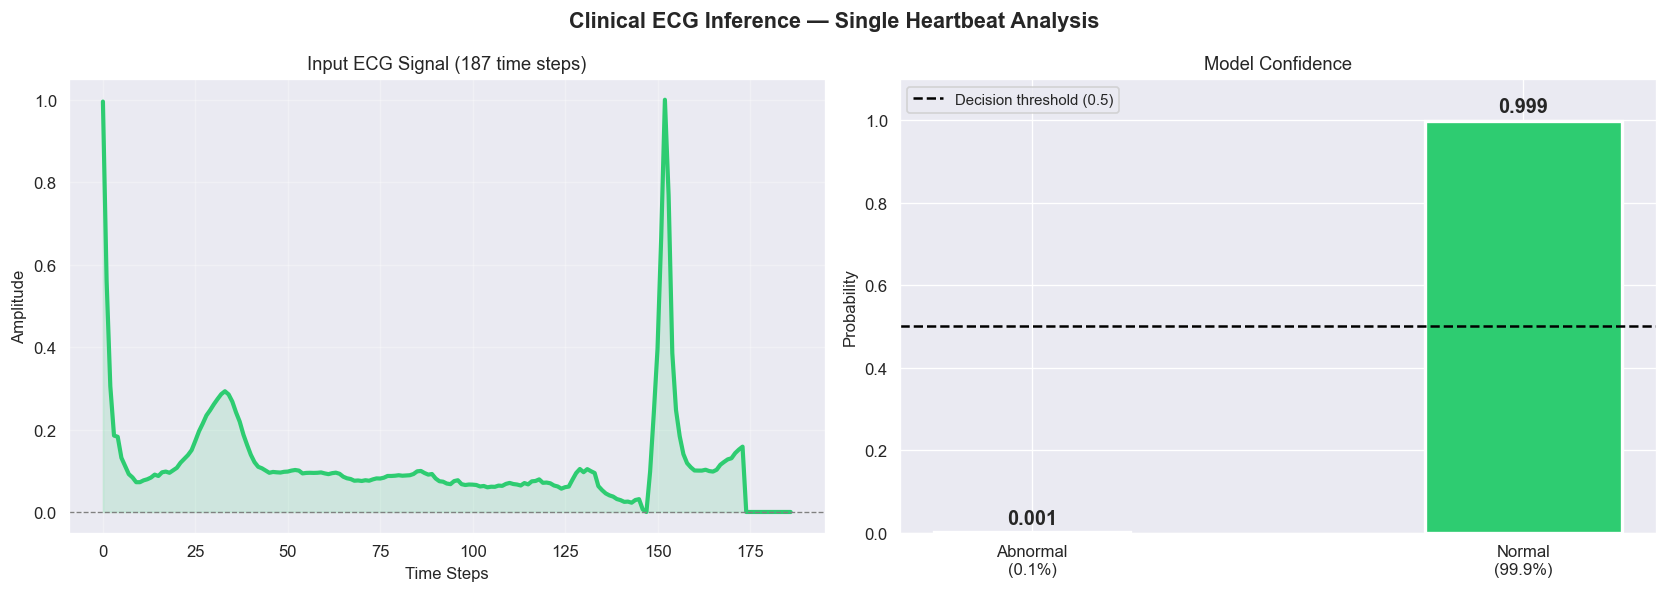

  CARDIAC MONITORING SYSTEM — INFERENCE REPORT
  Model Used         : CNN+LSTM
  Signal Length      : 187 time steps
  Decision Threshold : 0.5
  Abnormal Prob.     : 0.0007  (0.1%)
  Normal Prob.       : 0.9993  (99.9%)
-------------------------------------------------------
  PREDICTION  : ✅  NORMAL
  TRUE LABEL  : NORMAL
  RESULT      : CORRECT
  ACTION: No immediate action required.

--- Inference on an ABNORMAL heartbeat ---



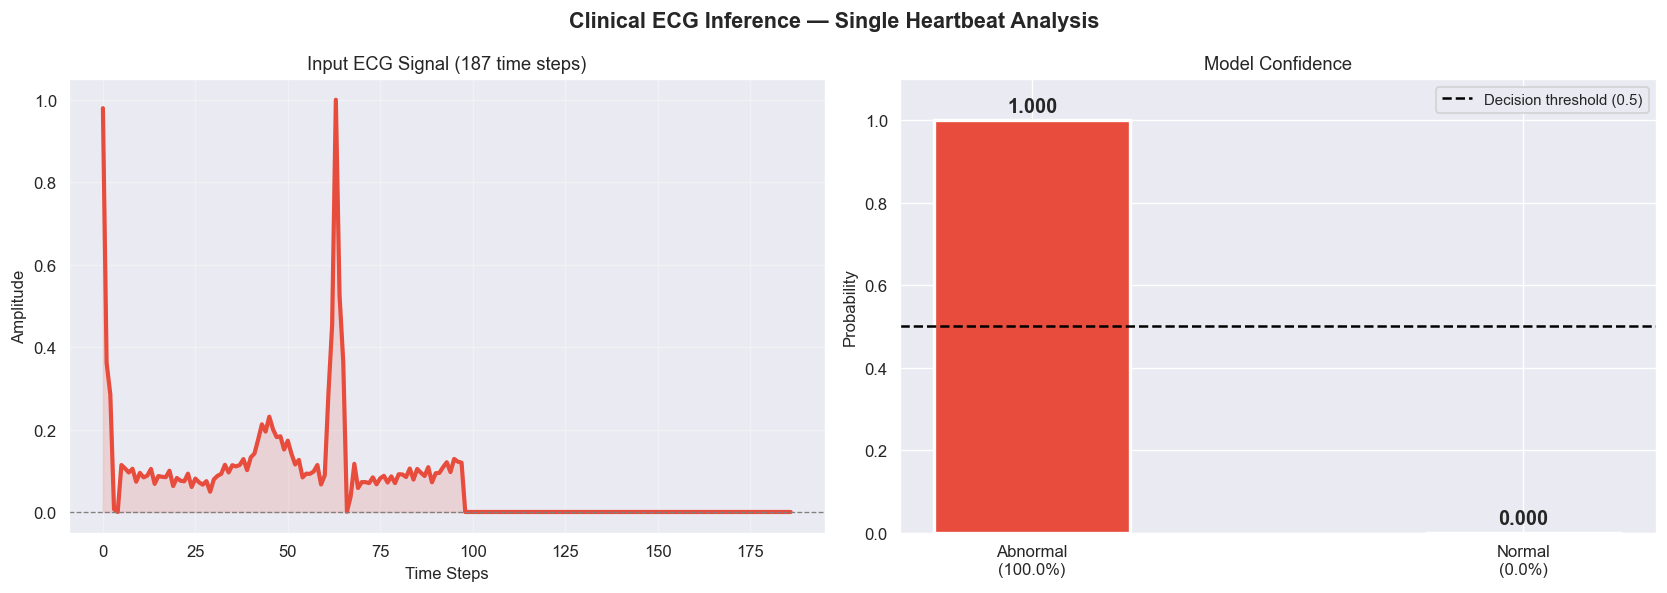

  CARDIAC MONITORING SYSTEM — INFERENCE REPORT
  Model Used         : CNN+LSTM
  Signal Length      : 187 time steps
  Decision Threshold : 0.5
  Abnormal Prob.     : 0.9999  (100.0%)
  Normal Prob.       : 0.0001  (0.0%)
-------------------------------------------------------
  PREDICTION  : ⚠️  ABNORMAL
  TRUE LABEL  : ABNORMAL
  RESULT      : CORRECT
  ACTION: Flag for cardiologist review.


In [24]:
def predict_single_signal(signal_array, true_label, model, device, threshold=0.5):
    """
    Simulate real-world inference on a single ECG heartbeat.

    Args:
        signal_array : np.array of shape (187,) — raw ECG signal values
        true_label   : int — ground truth (0=Normal, 1=Abnormal)
        model        : trained PyTorch model
        device       : torch.device
        threshold    : float — classification threshold (default 0.5)
    """
    model.eval()
    label_map = {0: 'NORMAL', 1: 'ABNORMAL'}

    # Preprocess: (187,) → tensor (1, 1, 187)
    tensor = torch.tensor(signal_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        prob = model(tensor).item()

    pred  = 1 if prob >= threshold else 0
    correct = (pred == true_label)

    # ── Clinical Report ──────────────────────────────────────
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    result_color = '#e74c3c' if pred == 1 else '#2ecc71'
    fig.suptitle('Clinical ECG Inference — Single Heartbeat Analysis',
                 fontsize=13, fontweight='bold')

    # Signal
    axes[0].plot(signal_array, color=result_color, linewidth=2.5)
    axes[0].fill_between(range(187), signal_array, alpha=0.15, color=result_color)
    axes[0].axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
    axes[0].set_title('Input ECG Signal (187 time steps)', fontsize=11)
    axes[0].set_xlabel('Time Steps'); axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)

    # Confidence gauge
    bar_vals  = [prob, 1 - prob]
    bar_lbls  = [f'Abnormal\n({prob:.1%})', f'Normal\n({1-prob:.1%})']
    bar_clrs  = ['#e74c3c', '#2ecc71']
    bars = axes[1].bar(bar_lbls, bar_vals, color=bar_clrs, width=0.4,
                       edgecolor='white', linewidth=2)
    axes[1].axhline(y=0.5, color='black', linewidth=1.5, linestyle='--', label='Decision threshold (0.5)')
    axes[1].set_ylim(0, 1.1)
    axes[1].set_title('Model Confidence', fontsize=11)
    axes[1].set_ylabel('Probability')
    axes[1].legend(fontsize=9)
    for bar, val in zip(bars, bar_vals):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{val:.3f}', ha='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Report
    print('=' * 55)
    print('  CARDIAC MONITORING SYSTEM — INFERENCE REPORT')
    print('=' * 55)
    print(f'  Model Used         : {winner}')
    print(f'  Signal Length      : 187 time steps')
    print(f'  Decision Threshold : {threshold}')
    print(f'  Abnormal Prob.     : {prob:.4f}  ({prob:.1%})')
    print(f'  Normal Prob.       : {1-prob:.4f}  ({1-prob:.1%})')
    print('-' * 55)
    print(f'  PREDICTION  : ⚠️  {label_map[pred]}' if pred == 1
          else f'  PREDICTION  : ✅  {label_map[pred]}')
    print(f'  TRUE LABEL  : {label_map[true_label]}')
    print(f'  RESULT      : {"CORRECT" if correct else "INCORRECT"}')
    print('=' * 55)

    if pred == 1:
        print('  ACTION: Flag for cardiologist review.')
    else:
        print('  ACTION: No immediate action required.')


# Demo on one normal and one abnormal sample
normal_test_idx   = np.where(y_test == 0)[0][0]
abnormal_test_idx = np.where(y_test == 1)[0][0]

print('--- Inference on a NORMAL heartbeat ---\n')
predict_single_signal(X_test[normal_test_idx], int(y_test[normal_test_idx]),
                      best_model, DEVICE)

print('\n--- Inference on an ABNORMAL heartbeat ---\n')
predict_single_signal(X_test[abnormal_test_idx], int(y_test[abnormal_test_idx]),
                      best_model, DEVICE)

---
# 23. Conclusion & Business Impact

## Project Summary

This project built a complete, end-to-end deep learning pipeline for ECG heartbeat classification —
starting from raw CSV signals and producing a clinically interpretable cardiac monitoring system.

---

## Technical Achievements

| Component | What Was Built |
|---|---|
| Architecture 1 | 1D CNN — 3 convolutional blocks with BatchNorm, GlobalAvgPool, Dense head |
| Architecture 2 | CNN + LSTM Hybrid — CNN feature extractor feeding into LSTM temporal modelling |
| Class Balancing | Upsampling to ensure equal representation of both classes |
| Training | Adam optimizer, ReduceLROnPlateau scheduler, EarlyStopping with weight restore |
| Evaluation | F1, AUC-ROC, Precision, Recall, Confusion Matrix with clinical annotation |
| Analysis | Best/worst case failure analysis to identify model limitations |
| Inference | Single-signal clinical simulation with decision report |

---

## Brain Tumor → ECG: The Full Journey

| Aspect | Brain Tumor Project | ECG Project |
|---|---|---|
| Data type | 2D images (MRI scans) | 1D signals (ECG heartbeats) |
| Task | Pixel-level segmentation | Binary classification |
| Primary model | U-Net + VGG16 | 1D CNN + LSTM |
| Conv type | Conv2d (slides over space) | Conv1d (slides over time) |
| Loss | BCE + Dice | BCE |
| Key metric | IoU + Dice Score | F1 + ROC-AUC |
| Output | 256×256 tumor mask | Probability of abnormality |
| Clinical use | Surgical planning | Cardiac monitoring |

---

## Business Value

**For Hospitals and ICUs:** Continuous automated ECG monitoring with instant abnormality alerts
— reducing the burden on nursing staff while ensuring nothing is missed during busy shifts.

**For Wearable Devices:** The 1D CNN architecture is lightweight enough to run
on edge hardware (smartwatches, patches) — enabling real-time monitoring outside clinical settings.

**For Developing Countries:** A trained model running on a tablet or low-cost device
can provide cardiologist-level ECG screening in regions where specialists are unavailable.

**For Preventive Healthcare:** Deployed at scale, this system shifts cardiac care
from reactive (treat after heart attack) to proactive (detect risk before events occur).

---

## Skills Demonstrated

- PyTorch deep learning pipeline — end to end, from raw CSV to clinical inference
- Time-series data understanding — ECG signal structure and medical context
- 1D Convolutional Neural Networks — temporal pattern recognition
- LSTM — sequential modelling and long-range temporal dependencies
- CNN + LSTM hybrid architecture design
- Class imbalance handling in medical datasets
- Clinical-grade evaluation — F1, AUC, Recall, Confusion Matrix with medical interpretation
- Failure analysis — identifying and understanding model errors

---

## Future Improvements

- **Transformer-based model** — Self-attention over time steps, state-of-the-art for time series
- **5-class MIT-BIH classification** — Extend to the full arrhythmia dataset for richer clinical value
- **Data augmentation** — Time-warping, amplitude scaling to improve generalization
- **Confidence calibration** — Platt scaling to make probability outputs more reliable
- **ONNX export** — Deploy model on edge devices (wearables, embedded systems)
- **Web app** — FastAPI backend where a clinician uploads ECG data and receives instant report
- **Explainability (Grad-CAM 1D)** — Highlight which time steps drove the model's decision

---
> *Built with PyTorch | ECG Heartbeat Classification Project*  
> *Part of a Medical AI Portfolio: Brain Tumor Segmentation → ECG Cardiac Monitoring*  
> *Author: Mohammed Panchla*
